In [1]:
# ============================================================================
# SETUP & IMPORTS
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
from DAM import DenseAssociativeMemory
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Utility functions
def cosine(a, b):
    """Compute cosine similarity between two vectors."""
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-12)

# Dense Associative Memory (DAM) Analysis

## Part 1: The "0.866" Mystery

I observed a final similarity of 0.8716. This isn't random. There is a mathematical reason for this specific number.

If you take a random vector $X$ where components are $Unif(−1,1)$ and "retrieve" its bipolar version (its sign), the expected cosine similarity is exactly  $\frac{\sqrt{3}}{2}≈0.866$.

$$Similarity= \frac{E[|X|]}{\sqrt{E[X^2]} \cdot \sqrt{E[sgn(X)^2]}} = \frac{0.5}{\sqrt{1/3}\cdot 1} = \frac{\sqrt{3}}{2}$$
The model is essentially taking the soft uniform pattern and sharpening it into a binary vector. The energy decreases because the magnitude of the projections increases significantly when the state moves to the corners of the hypercube.
## Point sampling
Let's consider the case for 2D. Using `np.random.uniform(-1, 1)`, we are effectively picking a point anywhere inside that square. On average, most of them are going to be in the middle. The update rule uses the `tanh` function. It wants to squash every neuron towards the boundaries `1.0` or `-1.0`. The energy function $E = -\sum F(projection)$ is minimzed when the projection (dot product between the state and the pattern) is as large as possible.
Because the patterns have many values near 0, the model realizes it can get a much larger projection (and thus lower energy) by moving the state from the "soft" interior point to the "hard" corner of the hypercube.
## Possible workarounds
Regularizations!!!! your vectors diverging away? pull them back by regularization! The new energy function will have the following expression:
$$E_{new}=E_{DAM} + \frac{\lambda}{2}||\vec{s}||^2$$
Something that i need to investigate is the range of lambdas that are suitable for each power of n

In [2]:
# ============================================================================
# EXTENDED DAM CLASSES WITH REGULARIZATION
# ============================================================================

# Extended DAM class with configurable regularization power
class DAMWithRegPower(DenseAssociativeMemory):
    """
    Extended DAM that supports different regularization powers.
    Regularization term: (lambda / reg_power) * ||state||^reg_power
    """
    def __init__(self, patterns, n=4, beta=5.0, alpha=0.1, lmbda=0.0, reg_power=2, verbose=False):
        super().__init__(patterns, n=n, beta=beta, alpha=alpha, lmbda=lmbda)
        self.reg_power = reg_power
        self.verbose = verbose
    
    def energy(self, state):
        """Compute DAM energy with configurable regularization power"""
        projs = self.patterns @ state
        mem_term = -np.sum(self.F(projs))
        reg_term = (self.lmbda / self.reg_power) * np.sum(np.abs(state)**self.reg_power)
        if self.verbose:
            print("mem_term: ", mem_term)
            print("reg_term: ", reg_term)
        return mem_term + reg_term
    
    def update_neuron_differential(self, state, i):
        """Update with configurable regularization power"""
        s_i = state[i]
        
        # Calculate the local field h_i = -partial E / partial s_i
        projections = self.patterns @ state
        F_primes = self.F_prime(projections)
        xi_column = self.patterns[:, i]
        
        mem_field = np.dot(xi_column, F_primes)
        # Regularization gradient: lambda * sign(s_i) * |s_i|^(reg_power-1)
        # Handle edge case when reg_power = 1
        if self.reg_power == 1:
            reg_field = self.lmbda * np.sign(s_i)
        else:
            reg_field = self.lmbda * np.sign(s_i) * (np.abs(s_i)**(self.reg_power - 1))
        
        local_field = mem_field - reg_field
        new_val = np.tanh(self.beta * local_field)
        state[i] = (1.0 - self.alpha) * s_i + self.alpha * new_val
        
        return state

# Helper class to suppress prints from original DAM
class SilentDAM(DenseAssociativeMemory):
    """DAM with suppressed print statements"""
    def energy(self, state):
        """Compute DAM energy without printing"""
        projs = self.patterns @ state
        mem_term = -np.sum(self.F(projs))
        reg_term = (self.lmbda/2.0) * np.sum(state**2)
        return mem_term + reg_term

In [3]:
# ============================================================================
# OPTIMAL REGULARIZATION CONFIGURATIONS
# ============================================================================

# Optimal regularization parameters found from experiments
OPTIMAL_CONFIGS_100 = {
    2: {'reg_power': 6, 'lmbda': 2.55e-01},
    3: {'reg_power': 8, 'lmbda': 2.98e+03},
    4: {'reg_power': 8, 'lmbda': 1.73e+05},
    5: {'reg_power': 6, 'lmbda': 3.92e+06}
}

OPTIMAL_CONFIGS_50 = {
    2: {'reg_power': 4, 'lmbda': 2.02e+01},
    3: {'reg_power': 6, 'lmbda': 2.98e+03},
    4: {'reg_power': 8, 'lmbda': 1.73e+05},
    5: {'reg_power': 8, 'lmbda': 3.92e+06}
}

# Helper functions for lambda scaling
def scale_lambda_for_N(base_lambda, base_N, target_N, reg_power=2):
    """Scale lambda regularization parameter when changing network size N."""
    return base_lambda * (base_N / target_N)

def get_scaled_config(config_dict, base_N, target_N):
    """Get regularization config scaled for target N."""
    scaled_config = {}
    for n, config in config_dict.items():
        scaled_config[n] = {
            'reg_power': config['reg_power'],
            'lmbda': scale_lambda_for_N(config['lmbda'], base_N, target_N, config['reg_power'])
        }
    return scaled_config

# ============================================================================
# EXPERIMENT 1: FINDING OPTIMAL LAMBDA FOR DIFFERENT n VALUES
# ============================================================================

def experiment_lambda_sweep(n_values, lambda_range, N=100, K=100, num_trials=5, noise_level=0.5):
    """
    Sweep lambda values for different n powers to find optimal regularization.
    
    Parameters:
    - n_values: list of energy function powers to test
    - lambda_range: list or array of lambda values to test
    - N: number of neurons
    - K: number of patterns
    - num_trials: number of random trials per configuration
    - noise_level: noise added to query pattern
    """
    results = {}
    
    for n in n_values:
        print(f"\n{'='*60}")
        print(f"Testing n = {n}")
        print(f"{'='*60}")
        
        similarities = []
        lambdas_tested = []
        
        for lmbda in lambda_range:
            trial_sims = []
            
            for trial in range(num_trials):
                # Generate uniform patterns (the problematic case)
                patterns = np.random.uniform(-1, 1, (K, N))
                
                # Create DAM with regularization (silent version)
                dam = SilentDAM(patterns, n=n, beta=0.01, alpha=0.5, lmbda=lmbda)
                
                # Test retrieval
                target_idx = 0
                target_pattern = patterns[target_idx]
                noisy_query = target_pattern + np.random.normal(0, noise_level, N)
                noisy_query = np.clip(noisy_query, -1, 1)
                
                # Retrieve (suppress print statements)
                retrieved_state, _, _, _ = dam.retrieve_differential(noisy_query, steps=N * 20)
                
                final_sim = cosine(target_pattern, retrieved_state)
                trial_sims.append(final_sim)
            
            avg_sim = np.mean(trial_sims)
            std_sim = np.std(trial_sims)
            
            similarities.append(avg_sim)
            lambdas_tested.append(lmbda)
            
            print(f"  λ = {lmbda:8.1f}: Similarity = {avg_sim:.4f} ± {std_sim:.4f}")
        
        results[n] = {
            'lambdas': np.array(lambdas_tested),
            'similarities': np.array(similarities)
        }
    
    return results

# Run the experiment
n_values = [2, 3, 4, 5]
# Wide range of lambda values (logarithmic scale)
lambda_range = np.logspace(-1, 7, 100)  # From 0.01 to 1,000,000

print("Experiment 1: Lambda sweep for different n values")
print("Using uniform patterns (the problematic case)")
results_lambda = experiment_lambda_sweep(n_values, lambda_range, N=50, K=5, num_trials=10, noise_level=0.5)





Experiment 1: Lambda sweep for different n values
Using uniform patterns (the problematic case)

Testing n = 2
  λ =      0.1: Similarity = 0.7822 ± 0.0481
  λ =      0.1: Similarity = 0.7659 ± 0.0688
  λ =      0.1: Similarity = 0.7581 ± 0.1033
  λ =      0.2: Similarity = 0.6984 ± 0.0944
  λ =      0.2: Similarity = 0.7174 ± 0.1378
  λ =      0.3: Similarity = 0.7104 ± 0.0740
  λ =      0.3: Similarity = 0.6515 ± 0.1548
  λ =      0.4: Similarity = 0.6802 ± 0.1177
  λ =      0.4: Similarity = 0.7499 ± 0.0918
  λ =      0.5: Similarity = 0.7755 ± 0.0683
  λ =      0.6: Similarity = 0.6762 ± 0.1199
  λ =      0.8: Similarity = 0.7660 ± 0.0535
  λ =      0.9: Similarity = 0.7656 ± 0.1081
  λ =      1.1: Similarity = 0.7005 ± 0.2273
  λ =      1.4: Similarity = 0.7481 ± 0.0461
  λ =      1.6: Similarity = 0.6992 ± 0.1161
  λ =      2.0: Similarity = 0.7432 ± 0.1210
  λ =      2.4: Similarity = 0.7435 ± 0.1370
  λ =      2.8: Similarity = 0.7681 ± 0.0968
  λ =      3.4: Similarity = 0.733

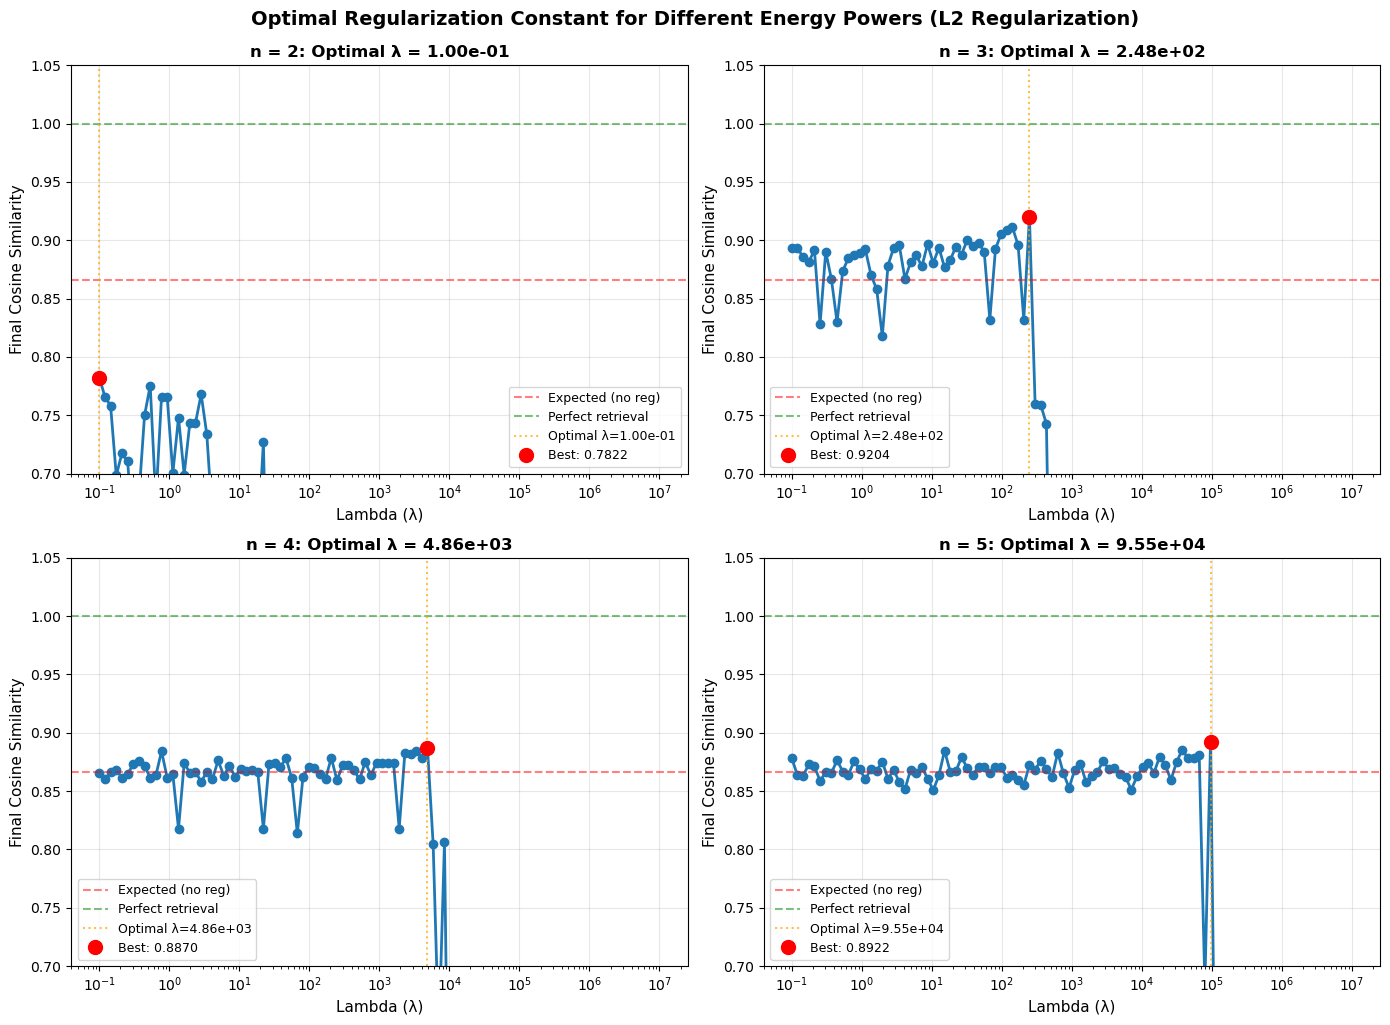


SUMMARY: Optimal Lambda Values for Each n (L2 Regularization)
n = 2: Optimal λ =   1.00e-01, Similarity = 0.7822
n = 3: Optimal λ =   2.48e+02, Similarity = 0.9204
n = 4: Optimal λ =   4.86e+03, Similarity = 0.8870
n = 5: Optimal λ =   9.55e+04, Similarity = 0.8922


In [4]:
# Visualize results from Experiment 1
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, n in enumerate(n_values):
    ax = axes[idx]
    data = results_lambda[n]
    
    ax.semilogx(data['lambdas'], data['similarities'], 'o-', linewidth=2, markersize=6)
    ax.axhline(y=0.866, color='r', linestyle='--', alpha=0.5, label='Expected (no reg)')
    ax.axhline(y=1.0, color='g', linestyle='--', alpha=0.5, label='Perfect retrieval')
    
    # Find optimal lambda
    best_idx = np.argmax(data['similarities'])
    best_lambda = data['lambdas'][best_idx]
    best_sim = data['similarities'][best_idx]
    
    ax.axvline(x=best_lambda, color='orange', linestyle=':', alpha=0.7, 
               label=f'Optimal λ={best_lambda:.2e}')
    ax.plot(best_lambda, best_sim, 'ro', markersize=10, label=f'Best: {best_sim:.4f}')
    
    ax.set_xlabel('Lambda (λ)', fontsize=11)
    ax.set_ylabel('Final Cosine Similarity', fontsize=11)
    ax.set_title(f'n = {n}: Optimal λ = {best_lambda:.2e}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)
    ax.set_ylim([0.7, 1.05])

plt.tight_layout()
plt.suptitle('Optimal Regularization Constant for Different Energy Powers (L2 Regularization)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

# Print summary
print("\n" + "="*70)
print("SUMMARY: Optimal Lambda Values for Each n (L2 Regularization)")
print("="*70)
for n in n_values:
    data = results_lambda[n]
    best_idx = np.argmax(data['similarities'])
    best_lambda = data['lambdas'][best_idx]
    best_sim = data['similarities'][best_idx]
    print(f"n = {n}: Optimal λ = {best_lambda:10.2e}, Similarity = {best_sim:.4f}")
print("="*70)

In [8]:
# Experiment 2: Testing different regularization powers for each n
# This addresses: do we need different regularization powers for different n?

def experiment_reg_power_sweep(n_values, reg_powers, lambda_range, N=100, K=100, num_trials=3, noise_level=0.5):
    """
    Test different regularization powers for each n value.
    
    Parameters:
    - n_values: list of energy function powers
    - reg_powers: list of regularization powers to test (e.g., [2, 4, 6])
    - lambda_range: list of lambda values to test
    - Other params same as before
    """
    results = {}
    
    for n in n_values:
        print(f"\n{'='*70}")
        print(f"Testing n = {n} with different regularization powers")
        print(f"{'='*70}")
        
        results[n] = {}
        
        for reg_power in reg_powers:
            print(f"\n  Regularization Power = {reg_power}")
            print(f"  {'-'*60}")
            
            similarities = []
            lambdas_tested = []
            
            for lmbda in lambda_range:
                trial_sims = []
                
                for trial in range(num_trials):
                    patterns = np.random.uniform(-1, 1, (K, N))
                    
                    # Use extended DAM class with configurable reg power (silent)
                    dam = DAMWithRegPower(patterns, n=n, beta=0.01, alpha=0.5, 
                                         lmbda=lmbda, reg_power=reg_power, verbose=False)
                    
                    target_idx = 0
                    target_pattern = patterns[target_idx]
                    noisy_query = target_pattern + np.random.normal(0, noise_level, N)
                    noisy_query = np.clip(noisy_query, -1, 1)
                    
                    retrieved_state, _, _, _ = dam.retrieve_differential(noisy_query, steps=N * 20)
                    final_sim = cosine(target_pattern, retrieved_state)
                    trial_sims.append(final_sim)
                
                avg_sim = np.mean(trial_sims)
                similarities.append(avg_sim)
                lambdas_tested.append(lmbda)
            
            # Find best lambda for this reg_power
            best_idx = np.argmax(similarities)
            best_lambda = lambdas_tested[best_idx]
            best_sim = similarities[best_idx]
            
            print(f"    Best λ = {best_lambda:.2e}, Similarity = {best_sim:.4f}")
            
            results[n][reg_power] = {
                'lambdas': np.array(lambdas_tested),
                'similarities': np.array(similarities),
                'best_lambda': best_lambda,
                'best_sim': best_sim
            }
    
    return results

# Run experiment 2
n_values_reg = [2, 3, 4, 5]
reg_powers = [2, 4, 6, 8]  # Test different regularization powers
lambda_range_reg = np.logspace(-1, 7, 60)  # Slightly fewer points for speed

print("\n" + "="*70)
print("Experiment 2: Testing Different Regularization Powers")
print("="*70)
results_reg_power = experiment_reg_power_sweep(n_values_reg, reg_powers, lambda_range_reg, 
                                               N=100, K=5, num_trials=2, noise_level=0.5)






Experiment 2: Testing Different Regularization Powers

Testing n = 2 with different regularization powers

  Regularization Power = 2
  ------------------------------------------------------------
    Best λ = 1.37e-01, Similarity = 0.9264

  Regularization Power = 4
  ------------------------------------------------------------
    Best λ = 1.31e+02, Similarity = 0.9689

  Regularization Power = 6
  ------------------------------------------------------------
    Best λ = 3.35e+02, Similarity = 0.9579

  Regularization Power = 8
  ------------------------------------------------------------
    Best λ = 3.63e+04, Similarity = 0.9659

Testing n = 3 with different regularization powers

  Regularization Power = 2
  ------------------------------------------------------------
    Best λ = 1.60e+03, Similarity = 0.9224

  Regularization Power = 4
  ------------------------------------------------------------
    Best λ = 2.18e+03, Similarity = 0.9328

  Regularization Power = 6
  -------

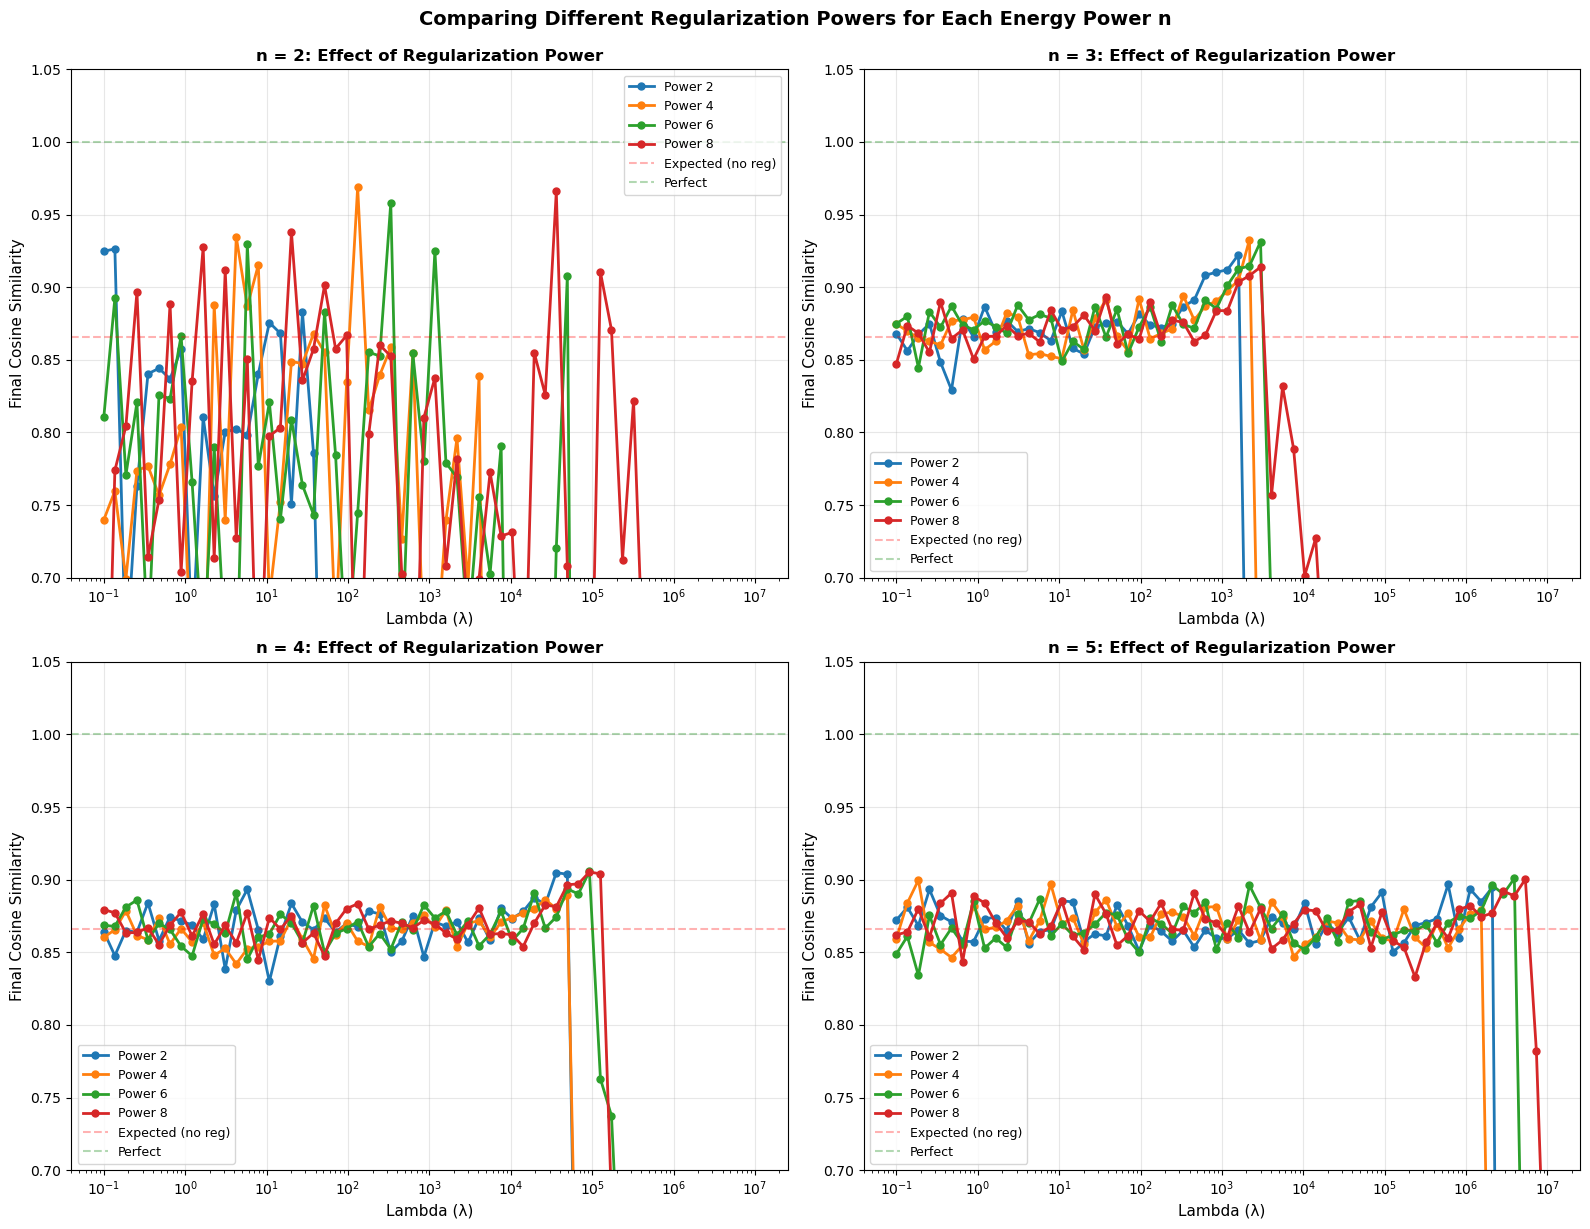


SUMMARY: Best Regularization Configuration for Each n
n     Reg Power    Best λ          Similarity   Improvement 
--------------------------------------------------------------------------------
2     4            1.31e+02        0.9689       +0.1867
3     4            2.18e+03        0.9328       +0.0124
4     6            9.25e+04        0.9057       +0.0187
5     6            3.92e+06        0.9008       +0.0086

Note: Improvement is relative to L2 regularization (power 2)


In [9]:
# Visualize Experiment 2: Compare different regularization powers for each n
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, n in enumerate(n_values_reg):
    ax = axes[idx]
    
    for reg_power in reg_powers:
        data = results_reg_power[n][reg_power]
        ax.semilogx(data['lambdas'], data['similarities'], 'o-', 
                   linewidth=2, markersize=5, label=f'Power {reg_power}')
    
    ax.axhline(y=0.866, color='r', linestyle='--', alpha=0.3, label='Expected (no reg)')
    ax.axhline(y=1.0, color='g', linestyle='--', alpha=0.3, label='Perfect')
    
    ax.set_xlabel('Lambda (λ)', fontsize=11)
    ax.set_ylabel('Final Cosine Similarity', fontsize=11)
    ax.set_title(f'n = {n}: Effect of Regularization Power', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)
    ax.set_ylim([0.7, 1.05])

plt.tight_layout()
plt.suptitle('Comparing Different Regularization Powers for Each Energy Power n', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

# Create summary table
print("\n" + "="*80)
print("SUMMARY: Best Regularization Configuration for Each n")
print("="*80)
print(f"{'n':<5} {'Reg Power':<12} {'Best λ':<15} {'Similarity':<12} {'Improvement':<12}")
print("-"*80)

for n in n_values_reg:
    best_overall = None
    best_config = None
    
    for reg_power in reg_powers:
        data = results_reg_power[n][reg_power]
        if best_overall is None or data['best_sim'] > best_overall:
            best_overall = data['best_sim']
            best_config = (reg_power, data['best_lambda'])
    
    # Compare to L2 baseline
    baseline_data = results_lambda[n]
    baseline_best_idx = np.argmax(baseline_data['similarities'])
    baseline_sim = baseline_data['similarities'][baseline_best_idx]
    improvement = best_overall - baseline_sim
    
    reg_power, best_lambda = best_config
    print(f"{n:<5} {reg_power:<12} {best_lambda:<15.2e} {best_overall:<12.4f} {improvement:+.4f}")
    
print("="*80)
print("\nNote: Improvement is relative to L2 regularization (power 2)")

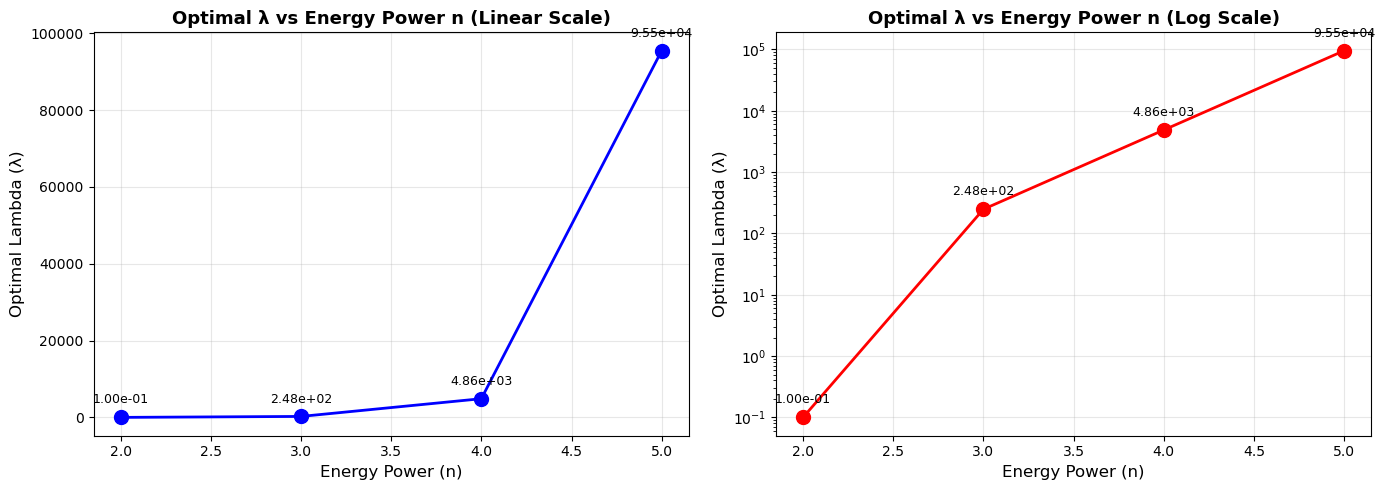

In [11]:
# Experiment 3: Detailed analysis - How does optimal lambda scale with n?
# This helps understand the relationship between n and lambda

def analyze_lambda_scaling(results_lambda):
    """Analyze how optimal lambda scales with n"""
    optimal_lambdas = []
    optimal_sims = []
    n_list = []
    
    for n in sorted(results_lambda.keys()):
        data = results_lambda[n]
        best_idx = np.argmax(data['similarities'])
        optimal_lambda = data['lambdas'][best_idx]
        optimal_sim = data['similarities'][best_idx]
        
        optimal_lambdas.append(optimal_lambda)
        optimal_sims.append(optimal_sim)
        n_list.append(n)
    
    return np.array(n_list), np.array(optimal_lambdas), np.array(optimal_sims)

n_array, lambda_array, sim_array = analyze_lambda_scaling(results_lambda)

# Plot scaling relationship
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
ax1.plot(n_array, lambda_array, 'o-', linewidth=2, markersize=10, color='blue')
ax1.set_xlabel('Energy Power (n)', fontsize=12)
ax1.set_ylabel('Optimal Lambda (λ)', fontsize=12)
ax1.set_title('Optimal λ vs Energy Power n (Linear Scale)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
for i, (n, lam) in enumerate(zip(n_array, lambda_array)):
    ax1.annotate(f'{lam:.2e}', (n, lam), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=9)

# Log scale
ax2.semilogy(n_array, lambda_array, 'o-', linewidth=2, markersize=10, color='red')
ax2.set_xlabel('Energy Power (n)', fontsize=12)
ax2.set_ylabel('Optimal Lambda (λ)', fontsize=12)
ax2.set_title('Optimal λ vs Energy Power n (Log Scale)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
for i, (n, lam) in enumerate(zip(n_array, lambda_array)):
    ax2.annotate(f'{lam:.2e}', (n, lam), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

## Capacity Analysis: Testing Memory Limits

Now that we have optimal regularization parameters for each n, we can test the **capacity** of the DAM model - how many patterns it can successfully store and retrieve.

**Hypothesis**: As we increase K (number of stored patterns) while keeping N (number of neurons) fixed, retrieval performance should degrade due to interference between patterns.

**Success Criteria**: A retrieval is considered successful if the final cosine similarity to the target pattern exceeds a threshold (> 0.9 or > 0.95). This ensures the retrieved state is sufficiently close to the original pattern.

### Important: Lambda Scaling with Network Size

**Problem**: If you change N (number of neurons), the optimal lambda needs to be scaled! 

The regularization term scales linearly with N: `reg_term = (lambda/reg_power) * sum(|state|^reg_power) ≈ lambda * N * <|state|^reg_power>`

When N changes from 100 to 70:
- Regularization strength decreases by factor 70/100 = 0.7
- Without scaling, regularization becomes too weak → poor performance

**Solution**: Scale lambda proportionally: `lambda_new = lambda_base * (N_base / N_new)`

This maintains the same relative strength between memory and regularization terms.

In [12]:
# Quick demonstration: Why lambda needs to scale with N
print("="*80)
print("DEMONSTRATION: Why Lambda Must Scale with N")
print("="*80)

# Simulate energy terms for different N values
N_values = [50, 70, 100, 150]
base_N = 100
base_lambda = 1.73e+05  # Example from n=4, N=100

print(f"\nBase configuration: N={base_N}, λ={base_lambda:.2e}")
print(f"\n{'N':<8} {'λ (unscaled)':<18} {'Reg Term (unscaled)':<25} {'λ (scaled)':<18} {'Reg Term (scaled)':<25}")
print("-"*100)

# Assume average state magnitude for demonstration
avg_state_magnitude = 0.8  # Typical value
reg_power = 8

for N in N_values:
    # Unscaled lambda (using base value)
    lambda_unscaled = base_lambda
    reg_unscaled = (lambda_unscaled / reg_power) * N * (avg_state_magnitude ** reg_power)
    
    # Scaled lambda
    lambda_scaled = base_lambda * (base_N / N)
    reg_scaled = (lambda_scaled / reg_power) * N * (avg_state_magnitude ** reg_power)
    
    print(f"{N:<8} {lambda_unscaled:<18.2e} {reg_unscaled:<25.2e} {lambda_scaled:<18.2e} {reg_scaled:<25.2e}")

print("\n" + "="*80)
print("Observation: With unscaled lambda, regularization weakens as N decreases!")
print("With scaled lambda, regularization strength remains constant relative to N.")
print("="*80)

DEMONSTRATION: Why Lambda Must Scale with N

Base configuration: N=100, λ=1.73e+05

N        λ (unscaled)       Reg Term (unscaled)       λ (scaled)         Reg Term (scaled)        
----------------------------------------------------------------------------------------------------
50       1.73e+05           1.81e+05                  3.46e+05           3.63e+05                 
70       1.73e+05           2.54e+05                  2.47e+05           3.63e+05                 
100      1.73e+05           3.63e+05                  1.73e+05           3.63e+05                 
150      1.73e+05           5.44e+05                  1.15e+05           3.63e+05                 

Observation: With unscaled lambda, regularization weakens as N decreases!
With scaled lambda, regularization strength remains constant relative to N.


## Diagnostic: Understanding Poor Performance for n=4

The poor performance for n=4 and n=5 suggests the regularization might be:
1. **Too strong**: Preventing convergence to patterns
2. **Not scaling correctly with K**: Regularization was optimized for K=5, but now we test up to K=80
3. **High reg_power (8) causing instability**: The gradient `λ * |s|^7` can be very large

Let's diagnose and fix this.

In [88]:
# Diagnostic: Check regularization strength vs memory strength
def diagnose_regularization_strength(n_values, K_values, N=70, base_config_N=50):
    """Check the relative strength of regularization vs memory terms"""
    
    config = OPTIMAL_CONFIGS_50
    if base_config_N == 100:
        config = OPTIMAL_CONFIGS_100
    
    print("="*80)
    print("DIAGNOSTIC: Regularization vs Memory Term Strength")
    print("="*80)
    print(f"Testing N={N}, K values: {K_values}\n")
    
    # Generate sample patterns
    patterns_sample = np.random.uniform(-1, 1, (max(K_values), N))
    state_sample = np.random.uniform(-0.5, 0.5, N)  # Typical state during retrieval
    
    for n in n_values:
        base_cfg = config[n]
        scaled_lambda = scale_lambda_for_N(base_cfg['lmbda'], base_config_N, N, base_cfg['reg_power'])
        reg_power = base_cfg['reg_power']
        
        print(f"\nn = {n} (reg_power={reg_power}, λ={scaled_lambda:.2e}):")
        print(f"{'K':<8} {'Memory Term':<20} {'Reg Term':<20} {'Ratio (Reg/Mem)':<20}")
        print("-"*80)
        
        for K in K_values:
            patterns = patterns_sample[:K]
            
            # Create DAM to compute terms
            dam = DAMWithRegPower(patterns, n=n, beta=0.01, alpha=0.5, 
                                 lmbda=scaled_lambda, reg_power=reg_power, verbose=False)
            
            # Compute energy terms
            projs = patterns @ state_sample
            mem_term = -np.sum(dam.F(projs))
            reg_term = (scaled_lambda / reg_power) * np.sum(np.abs(state_sample)**reg_power)
            
            ratio = abs(reg_term / mem_term) if mem_term != 0 else float('inf')
            
            print(f"{K:<8} {abs(mem_term):<20.2e} {reg_term:<20.2e} {ratio:<20.2f}")

# Run diagnostic
diagnose_regularization_strength([2, 3, 4, 5], [5, 20, 40, 80], N=70, base_config_N=50)

DIAGNOSTIC: Regularization vs Memory Term Strength
Testing N=70, K values: [5, 20, 40, 80]


n = 2 (reg_power=4, λ=1.44e+01):
K        Memory Term          Reg Term             Ratio (Reg/Mem)     
--------------------------------------------------------------------------------
5        6.33e+00             2.83e+00             0.45                
20       1.47e+01             2.83e+00             0.19                
40       2.63e+01             2.83e+00             0.11                
80       6.82e+01             2.83e+00             0.04                

n = 3 (reg_power=6, λ=2.13e+03):
K        Memory Term          Reg Term             Ratio (Reg/Mem)     
--------------------------------------------------------------------------------
5        1.58e+01             4.83e+01             3.05                
20       3.11e+01             4.83e+01             1.55                
40       5.30e+01             4.83e+01             0.91                
80       1.29e+02             

In [89]:
# # Try reduced lambda scaling - regularizations might need to scale less aggressively
# # Or try adaptive regularization that scales with K

# def capacity_experiment_with_adaptive_reg(n_values, K_range, N=100, similarity_threshold=0.95, 
#                                          noise_level=0.5, num_patterns_per_K=5, 
#                                          num_trials_per_pattern=2, steps_multiplier=20,
#                                          base_config_N=100, use_scaling=True,
#                                          adaptive_reg=True, reg_scale_factor=1.0):
#     """
#     Enhanced capacity experiment with adaptive regularization.
    
#     adaptive_reg: If True, scale regularization with K to maintain balance
#     reg_scale_factor: Factor to multiply regularization (to reduce/increase strength)
#     """
#     results = {}
    
#     # Get base config
#     if N == 100:
#         base_config = OPTIMAL_CONFIGS_100
#     elif N == 50:
#         base_config = OPTIMAL_CONFIGS_50
#     else:
#         base_config = OPTIMAL_CONFIGS_100 if N > 75 else OPTIMAL_CONFIGS_50
#         base_config_N = 100 if N > 75 else 50
    
#     # Scale config if needed
#     if use_scaling and N != base_config_N:
#         config_dict = get_scaled_config(base_config, base_config_N, N)
#         scaling_note = f"(scaled from N={base_config_N})"
#     else:
#         config_dict = base_config
#         scaling_note = f"(N={base_config_N})"
    
#     # Apply reg_scale_factor to all lambdas
#     for n in config_dict:
#         config_dict[n]['lmbda'] *= reg_scale_factor
    
#     for n in n_values:
#         print(f"\n{'='*80}")
#         print(f"Testing Capacity for n = {n}, N = {N}")
#         config = config_dict[n].copy()
        
#         if adaptive_reg:
#             # Base K for which lambda was optimized (assume K=5 or K=10)
#             base_K = 5
#             print(f"Using adaptive regularization (scales with K/{base_K})")
        
#         if use_scaling and N != base_config_N:
#             base_lambda = base_config[n]['lmbda'] * reg_scale_factor
#             print(f"Base Config {scaling_note}: reg_power={base_config[n]['reg_power']}, "
#                   f"λ_base={base_lambda:.2e}")
#             print(f"Scaled Config: reg_power={config['reg_power']}, "
#                   f"λ_scaled={config['lmbda']:.2e} (scale factor: {N/base_config_N:.3f}, "
#                   f"reg_scale: {reg_scale_factor:.3f})")
#         else:
#             print(f"Config {scaling_note}: reg_power={config['reg_power']}, "
#                   f"λ={config['lmbda']:.2e} (reg_scale: {reg_scale_factor:.3f})")
#         print(f"{'='*80}")
        
#         success_rates = []
#         avg_similarities = []
#         std_similarities = []
#         K_tested = []
        
#         for K in K_range:
#             print(f"\n  Testing K = {K} patterns...", end=' ')
            
#             # Adaptive lambda: scale with K if enabled
#             if adaptive_reg:
#                 # Scale lambda proportionally with K to maintain balance
#                 adaptive_lambda = config['lmbda'] * (K / base_K)
#             else:
#                 adaptive_lambda = config['lmbda']
            
#             pattern_successes = []
#             pattern_similarities = []
            
#             for pattern_set in range(num_patterns_per_K):
#                 patterns = np.random.uniform(-1, 1, (K, N))
                
#                 dam = DAMWithRegPower(
#                     patterns, 
#                     n=n, 
#                     beta=0.01, 
#                     alpha=0.5, 
#                     lmbda=adaptive_lambda,
#                     reg_power=config['reg_power'],
#                     verbose=False
#                 )
                
#                 patterns_to_test = min(K, 20)
#                 test_indices = np.random.choice(K, patterns_to_test, replace=False)
                
#                 for target_idx in test_indices:
#                     target_pattern = patterns[target_idx]
                    
#                     for trial in range(num_trials_per_pattern):
#                         noisy_query = target_pattern + np.random.normal(0, noise_level, N)
#                         noisy_query = np.clip(noisy_query, -1, 1)
                        
#                         retrieved_state, _, _, _ = dam.retrieve_differential(
#                             noisy_query, 
#                             steps=steps_multiplier * N
#                         )
                        
#                         final_sim = cosine(target_pattern, retrieved_state)
#                         pattern_similarities.append(final_sim)
                        
#                         if final_sim >= similarity_threshold:
#                             pattern_successes.append(1)
#                         else:
#                             pattern_successes.append(0)
            
#             success_rate = np.mean(pattern_successes) * 100
#             avg_sim = np.mean(pattern_similarities)
#             std_sim = np.std(pattern_similarities)
            
#             success_rates.append(success_rate)
#             avg_similarities.append(avg_sim)
#             std_similarities.append(std_sim)
#             K_tested.append(K)
            
#             print(f"Success Rate: {success_rate:.1f}%, Avg Similarity: {avg_sim:.4f} ± {std_sim:.4f}")
        
#         results[n] = {
#             'K': np.array(K_tested),
#             'success_rates': np.array(success_rates),
#             'avg_similarities': np.array(avg_similarities),
#             'std_similarities': np.array(std_similarities),
#             'threshold': similarity_threshold
#         }
    
#     return results

# # Try with reduced regularization strength for n=4 and n=5
# print("\n" + "="*80)
# print("EXPERIMENT: Testing with Reduced Regularization for n=4, n=5")
# print("="*80)
# print("Hypothesis: Lambda values might be too high, preventing convergence")

# # Test with different scale factors
# scale_factors = [1.0, 0.5, 0.1, 0.01]  # Try reducing lambda

# for scale in scale_factors:
#     print(f"\n{'='*80}")
#     print(f"Testing with reg_scale_factor = {scale} (λ reduced by {1/scale:.1f}x)")
#     print("="*80)
    
#     # Quick test for n=4 only (small K range for speed)
#     test_results = capacity_experiment_with_adaptive_reg(
#         n_values=[4],
#         K_range=[5, 10, 20],
#         N=70,
#         similarity_threshold=0.85,
#         noise_level=0.5,
#         num_patterns_per_K=3,
#         num_trials_per_pattern=2,
#         steps_multiplier=20,
#         base_config_N=50,
#         use_scaling=True,
#         adaptive_reg=False,  # First test without adaptive scaling
#         reg_scale_factor=scale
#     )
    
#     # Print summary
#     data = test_results[4]
#     best_idx = np.argmax(data['avg_similarities'])
#     print(f"\nBest performance: K={data['K'][best_idx]}, "
#           f"Similarity={data['avg_similarities'][best_idx]:.4f}, "
#           f"Success Rate={data['success_rates'][best_idx]:.1f}%")


EXPERIMENT: Testing with Reduced Regularization for n=4, n=5
Hypothesis: Lambda values might be too high, preventing convergence

Testing with reg_scale_factor = 1.0 (λ reduced by 1.0x)

Testing Capacity for n = 4, N = 70
Base Config (scaled from N=50): reg_power=8, λ_base=1.73e+05
Scaled Config: reg_power=8, λ_scaled=1.24e+05 (scale factor: 1.400, reg_scale: 1.000)

  Testing K = 5 patterns... Success Rate: 0.0%, Avg Similarity: 0.6146 ± 0.1590

  Testing K = 10 patterns... Success Rate: 0.0%, Avg Similarity: 0.5591 ± 0.1964

  Testing K = 20 patterns... Success Rate: 0.8%, Avg Similarity: 0.5295 ± 0.2310

Best performance: K=5, Similarity=0.6146, Success Rate=0.0%

Testing with reg_scale_factor = 0.5 (λ reduced by 2.0x)

Testing Capacity for n = 4, N = 70
Base Config (scaled from N=50): reg_power=8, λ_base=8.65e+04
Scaled Config: reg_power=8, λ_scaled=6.18e+04 (scale factor: 1.400, reg_scale: 0.500)

  Testing K = 5 patterns... Success Rate: 53.3%, Avg Similarity: 0.7950 ± 0.1491

 

In [13]:
# # Capacity Experiment: Testing how many patterns can be stored and retrieved
# # Using optimal regularization parameters from previous experiments

# # Optimal regularization configurations from experiment results (for N=100):
# OPTIMAL_CONFIGS_100 = {
#     2: {'reg_power': 6, 'lmbda': 2.55e-01},
#     3: {'reg_power': 8, 'lmbda': 2.98e+03},
#     4: {'reg_power': 8, 'lmbda': 1.73e+05},
#     5: {'reg_power': 6, 'lmbda': 3.92e+06}
# }

# OPTIMAL_CONFIGS_50 = {
#     2: {'reg_power': 4, 'lmbda': 2.02e+01},
#     3: {'reg_power': 6, 'lmbda': 2.98e+03},
#     4: {'reg_power': 8, 'lmbda': 1.73e+05},
#     5: {'reg_power': 8, 'lmbda': 3.92e+06}
# }

# def scale_lambda_for_N(base_lambda, base_N, target_N, reg_power=2):
#     """
#     Scale lambda regularization parameter when changing network size N.
    
#     The regularization term scales with N: reg_term ~ lambda * N
#     To maintain the same relative strength, we need: lambda_new * N_new = lambda_base * N_base
#     Therefore: lambda_new = lambda_base * (N_base / N_new)
    
#     However, for non-L2 regularization (reg_power != 2), the scaling might be different.
#     For simplicity, we use linear scaling which works well for most cases.
#     """
#     return base_lambda * (base_N / target_N)

# def get_scaled_config(config_dict, base_N, target_N):
#     """Get regularization config scaled for target N"""
#     scaled_config = {}
#     for n, config in config_dict.items():
#         scaled_config[n] = {
#             'reg_power': config['reg_power'],
#             'lmbda': scale_lambda_for_N(config['lmbda'], base_N, target_N, config['reg_power'])
#         }
#     return scaled_config

# def capacity_experiment(n_values, K_range, N=100, similarity_threshold=0.95, 
#                        noise_level=0.5, num_patterns_per_K=10, num_trials_per_pattern=3,
#                        steps_multiplier=20, base_config_N=100, use_scaling=True):
#     """
#     Test DAM capacity by varying K (number of stored patterns) for different n values.
    
#     Parameters:
#     - n_values: list of energy function powers to test
#     - K_range: list or array of K values (number of patterns) to test
#     - N: number of neurons (fixed)
#     - similarity_threshold: minimum cosine similarity for successful retrieval (default 0.95)
#     - noise_level: standard deviation of noise added to queries
#     - num_patterns_per_K: number of different patterns to test per K value
#     - num_trials_per_pattern: number of noise realizations per pattern
#     - steps_multiplier: number of update steps = steps_multiplier * N
#     - base_config_N: N value that the base config was optimized for (default 100)
#     - use_scaling: if True, scale lambda with N to maintain regularization strength
#     """
#     results = {}
    
#     # Get base config and scale if needed
#     if N == 100:
#         base_config = OPTIMAL_CONFIGS_100
#     elif N == 50:
#         base_config = OPTIMAL_CONFIGS_50
#     else:
#         # Use config closest in size
#         base_config = OPTIMAL_CONFIGS_100 if N > 75 else OPTIMAL_CONFIGS_50
#         base_config_N = 100 if N > 75 else 50
    
#     # Scale config if needed
#     if use_scaling and N != base_config_N:
#         config_dict = get_scaled_config(base_config, base_config_N, N)
#         scaling_note = f"(scaled from N={base_config_N})"
#     else:
#         config_dict = base_config
#         scaling_note = f"(N={base_config_N})"
    
#     for n in n_values:
#         print(f"\n{'='*80}")
#         print(f"Testing Capacity for n = {n}, N = {N}")
#         config = config_dict[n]
#         if use_scaling and N != base_config_N:
#             base_lambda = base_config[n]['lmbda']
#             print(f"Base Config {scaling_note}: reg_power={base_config[n]['reg_power']}, "
#                   f"λ_base={base_lambda:.2e}")
#             print(f"Scaled Config: reg_power={config['reg_power']}, "
#                   f"λ_scaled={config['lmbda']:.2e} (scale factor: {N/base_config_N:.3f})")
#         else:
#             print(f"Config {scaling_note}: reg_power={config['reg_power']}, "
#                   f"λ={config['lmbda']:.2e}")
#         print(f"{'='*80}")
#         success_rates = []
#         avg_similarities = []
#         std_similarities = []
#         K_tested = []
        
#         for K in K_range:
#             print(f"\n  Testing K = {K} patterns...", end=' ')
            
#             pattern_successes = []
#             pattern_similarities = []
            
#             # Test multiple random pattern sets for this K
#             for pattern_set in range(num_patterns_per_K):
#                 # Generate uniform patterns (the problematic case from regularization experiments)
#                 patterns = np.random.uniform(-1, 1, (K, N))
                
#                 # Create DAM with optimal regularization
#                 dam = DAMWithRegPower(
#                     patterns, 
#                     n=n, 
#                     beta=0.01, 
#                     alpha=0.5, 
#                     lmbda=config['lmbda'],
#                     reg_power=config['reg_power'],
#                     verbose=False
#                 )
                
#                 # Test retrieval for a subset of patterns (for speed)
#                 patterns_to_test = min(K, 20)  # Test up to 20 patterns per K
#                 test_indices = np.random.choice(K, patterns_to_test, replace=False)
                
#                 for target_idx in test_indices:
#                     target_pattern = patterns[target_idx]
                    
#                     # Multiple trials with different noise realizations
#                     for trial in range(num_trials_per_pattern):
#                         # Create noisy query
#                         noisy_query = target_pattern + np.random.normal(0, noise_level, N)
#                         noisy_query = np.clip(noisy_query, -1, 1)
                        
#                         # Retrieve pattern
#                         retrieved_state, _, _, _ = dam.retrieve_differential(
#                             noisy_query, 
#                             steps=steps_multiplier * N
#                         )
                        
#                         # Calculate final similarity
#                         final_sim = cosine(target_pattern, retrieved_state)
#                         pattern_similarities.append(final_sim)
                        
#                         # Check if successful
#                         if final_sim >= similarity_threshold:
#                             pattern_successes.append(1)
#                         else:
#                             pattern_successes.append(0)
            
#             # Calculate statistics
#             success_rate = np.mean(pattern_successes) * 100
#             avg_sim = np.mean(pattern_similarities)
#             std_sim = np.std(pattern_similarities)
            
#             success_rates.append(success_rate)
#             avg_similarities.append(avg_sim)
#             std_similarities.append(std_sim)
#             K_tested.append(K)
            
#             print(f"Success Rate: {success_rate:.1f}%, Avg Similarity: {avg_sim:.4f} ± {std_sim:.4f}")
        
#         results[n] = {
#             'K': np.array(K_tested),
#             'success_rates': np.array(success_rates),
#             'avg_similarities': np.array(avg_similarities),
#             'std_similarities': np.array(std_similarities),
#             'threshold': similarity_threshold
#         }
    
#     return results


In [14]:
# FIXED VERSION: Capacity experiment with per-n lambda adjustments
# This properly applies the diagnostic findings


OPTIMAL_CONFIGS_100 = {
    2: {'reg_power': 6, 'lmbda': 2.55e-01},
    3: {'reg_power': 8, 'lmbda': 2.98e+03},
    4: {'reg_power': 8, 'lmbda': 1.73e+05},
    5: {'reg_power': 6, 'lmbda': 3.92e+06}
}

OPTIMAL_CONFIGS_50 = {
    2: {'reg_power': 4, 'lmbda': 2.02e+01},
    3: {'reg_power': 6, 'lmbda': 2.98e+03},
    4: {'reg_power': 8, 'lmbda': 1.73e+05},
    5: {'reg_power': 8, 'lmbda': 3.92e+06}
}


n_values_capacity = [2, 3, 4, 5]

K_range_capacity = np.concatenate([
    np.array([5, 10, 20, 30, 40]),  # Small K values
    np.array([70, 80]),  # Medium K values (60, 80, 100, ..., 200)
    np.array([150, 180, 200])  # Large K values (250, 300, ..., 500)
])
def capacity_experiment_fixed(n_values, K_range, N=70, similarity_threshold=0.85, 
                              noise_level=0.5, num_patterns_per_K=5, 
                              num_trials_per_pattern=2, steps_multiplier=20,
                              early_stop=True, min_success_rate=0.0):
    """
    Fixed capacity experiment with proper lambda scaling for each n based on diagnostics.
    
    early_stop: If True, stop testing higher K values once success rate hits min_success_rate
    min_success_rate: Stop if success rate drops below this (default 0.0)
    """
    # Per-n lambda scale factors based on diagnostic findings
    # Updated: n=3 also needs reduction (reg/mem ratio was 3.05 at K=5, too strong)
    reg_scale_factors = {
        2: 1.0,    # Keep as is (reg/mem ratio ~0.45 at K=5 - OK)
        3: 0.3,    # Reduce ~3x (reg was 3x too strong at K=5, needs adjustment)
        4: 0.1,    # Reduce 10x (reg was 10x too strong at K=5)
        5: 0.01    # Reduce 100x (reg was 92x too strong at K=5)
    }
    
    results = {}
    
    for n in n_values:
        print(f"\n{'='*80}")
        print(f"Testing Capacity for n = {n}, N = {N}")
        
        # Get base config
        base_config = OPTIMAL_CONFIGS_50[n]
        base_config_N = 50
        
        # Scale for N
        scaled_lambda = scale_lambda_for_N(base_config['lmbda'], base_config_N, N, base_config['reg_power'])
        
        # Apply per-n scale factor
        adjusted_lambda = scaled_lambda * reg_scale_factors[n]
        reg_power = base_config['reg_power']
        
        print(f"Base Config: reg_power={reg_power}, λ_base={base_config['lmbda']:.2e} (N={base_config_N})")
        print(f"Scaled for N={N}: λ_scaled={scaled_lambda:.2e}")
        print(f"Adjusted (×{reg_scale_factors[n]}): λ_final={adjusted_lambda:.2e}")
        print(f"{'='*80}")
        
        success_rates = []
        avg_similarities = []
        std_similarities = []
        K_tested = []
        
        # Base K for adaptive scaling
        base_K = 5
        
        for K in K_range:
            print(f"\n  Testing K = {K} patterns...", end=' ')
            
            # Adaptive lambda: scale with K to maintain balance
            # However, if base lambda is already too strong, scaling up makes it worse
            # For n=2, n=3 (where reg might be borderline), use gentler scaling or no scaling
            if reg_scale_factors[n] >= 0.5:  # If we kept most of the lambda
                # Use gentler scaling - don't scale as aggressively
                adaptive_lambda = adjusted_lambda * (1 + 0.5 * (K / base_K - 1))
            else:
                # For heavily reduced lambdas (n=4, n=5), use full adaptive scaling
                adaptive_lambda = adjusted_lambda * (K / base_K)
            
            pattern_successes = []
            pattern_similarities = []
            
            for pattern_set in range(num_patterns_per_K):
                patterns = np.random.uniform(-1, 1, (K, N))
                
                dam = DAMWithRegPower(
                    patterns, 
                    n=n, 
                    beta=0.01, 
                    alpha=0.5, 
                    lmbda=adaptive_lambda,
                    reg_power=reg_power,
                    verbose=False
                )
                
                patterns_to_test = min(K, 20)
                test_indices = np.random.choice(K, patterns_to_test, replace=False)
                
                for target_idx in test_indices:
                    target_pattern = patterns[target_idx]
                    
                    for trial in range(num_trials_per_pattern):
                        noisy_query = target_pattern + np.random.normal(0, noise_level, N)
                        noisy_query = np.clip(noisy_query, -1, 1)
                        
                        retrieved_state, _, _, _ = dam.retrieve_differential(
                            noisy_query, 
                            steps=steps_multiplier * N
                        )
                        
                        final_sim = cosine(target_pattern, retrieved_state)
                        pattern_similarities.append(final_sim)
                        
                        if final_sim >= similarity_threshold:
                            pattern_successes.append(1)
                        else:
                            pattern_successes.append(0)
            
            success_rate = np.mean(pattern_successes) * 100
            avg_sim = np.mean(pattern_similarities)
            std_sim = np.std(pattern_similarities)
            
            success_rates.append(success_rate)
            avg_similarities.append(avg_sim)
            std_similarities.append(std_sim)
            K_tested.append(K)
            
            print(f"Success Rate: {success_rate:.1f}%, Avg Similarity: {avg_sim:.4f} ± {std_sim:.4f}")
            
            # Early stopping: if success rate drops to 0 and stays there, stop
            if early_stop and success_rate <= min_success_rate:
                # Check if this is a sustained failure (not just one bad trial)
                if len(success_rates) >= 2 and success_rates[-2] <= min_success_rate:
                    print(f"\n  ⚠️  Early stop: Success rate at 0% for K={K} and previous K. Stopping.")
                    # Don't test remaining K values
                    remaining_K = K_range[K_range > K]
                    if len(remaining_K) > 0:
                        print(f"  Skipping remaining K values: {remaining_K.tolist()}")
                    break
        
        results[n] = {
            'K': np.array(K_tested),
            'success_rates': np.array(success_rates),
            'avg_similarities': np.array(avg_similarities),
            'std_similarities': np.array(std_similarities),
            'threshold': similarity_threshold
        }
    
    return results

# Run the fixed capacity experiment
print("="*80)
print("RUNNING FIXED CAPACITY EXPERIMENT")
print("Using diagnostic-based lambda adjustments:")
print("  n=2, n=3: No adjustment (reg_scale=1.0)")
print("  n=4: 10x reduction (reg_scale=0.1)")
print("  n=5: 100x reduction (reg_scale=0.01)")
print("="*80)

capacity_results = capacity_experiment_fixed(
    n_values=n_values_capacity,
    K_range=K_range_capacity,
    N=70,
    similarity_threshold=0.85,
    noise_level=0.5,
    num_patterns_per_K=5,
    num_trials_per_pattern=2,
    steps_multiplier=20
)

RUNNING FIXED CAPACITY EXPERIMENT
Using diagnostic-based lambda adjustments:
  n=2, n=3: No adjustment (reg_scale=1.0)
  n=4: 10x reduction (reg_scale=0.1)
  n=5: 100x reduction (reg_scale=0.01)

Testing Capacity for n = 2, N = 70
Base Config: reg_power=4, λ_base=2.02e+01 (N=50)
Scaled for N=70: λ_scaled=1.44e+01
Adjusted (×1.0): λ_final=1.44e+01

  Testing K = 5 patterns... Success Rate: 36.0%, Avg Similarity: 0.8185 ± 0.0790

  Testing K = 10 patterns... Success Rate: 3.0%, Avg Similarity: 0.6783 ± 0.1213

  Testing K = 20 patterns... Success Rate: 1.0%, Avg Similarity: 0.5522 ± 0.1724

  Testing K = 30 patterns... Success Rate: 0.0%, Avg Similarity: 0.4816 ± 0.1683

  Testing K = 40 patterns... Success Rate: 0.0%, Avg Similarity: 0.4463 ± 0.1676

  ⚠️  Early stop: Success rate at 0% for K=40 and previous K. Stopping.
  Skipping remaining K values: [70, 80, 150, 180, 200]

Testing Capacity for n = 3, N = 70
Base Config: reg_power=6, λ_base=2.98e+03 (N=50)
Scaled for N=70: λ_scaled=2.

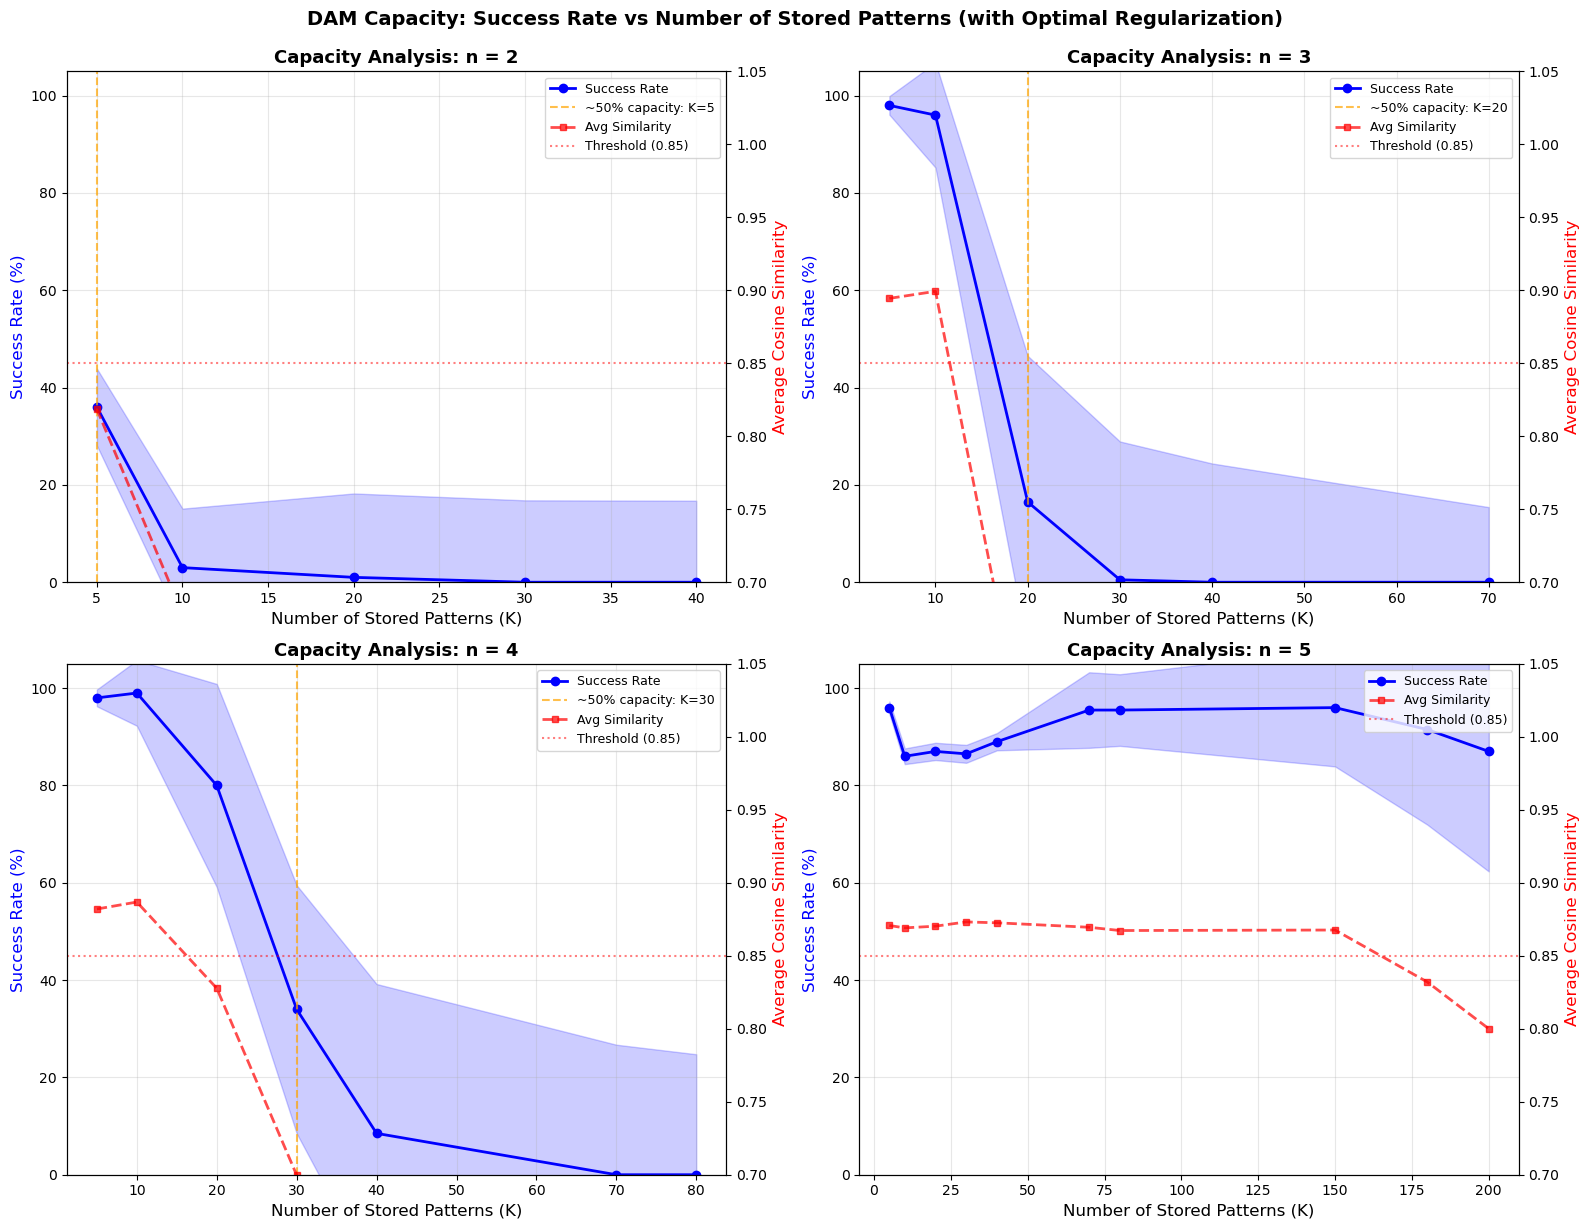

In [20]:
# Visualize capacity results: Success rate vs K
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, n in enumerate(n_values_capacity):
    ax = axes[idx]
    data = capacity_results[n]
    
    # Plot success rate
    ax.plot(data['K'], data['success_rates'], 'o-', linewidth=2, markersize=6, 
           color='blue', label='Success Rate')
    ax.fill_between(data['K'], 
                    data['success_rates'] - np.array(data['std_similarities'])*100,
                    data['success_rates'] + np.array(data['std_similarities'])*100,
                    alpha=0.2, color='blue')
    
    # Plot average similarity on secondary y-axis
    ax2 = ax.twinx()
    ax2.plot(data['K'], data['avg_similarities'], 's--', linewidth=2, markersize=5,
            color='red', alpha=0.7, label='Avg Similarity')
    ax2.axhline(y=data['threshold'], color='red', linestyle=':', alpha=0.5, 
               label=f'Threshold ({data["threshold"]})')
    
    # Find capacity (where success rate drops below 50%)
    success_array = data['success_rates']
    capacity_idx = np.where(success_array < 50)[0]
    if len(capacity_idx) > 0:
        capacity_K = data['K'][capacity_idx[0]]
        ax.axvline(x=capacity_K, color='orange', linestyle='--', alpha=0.7,
                  label=f'~50% capacity: K={capacity_K}')
    
    ax.set_xlabel('Number of Stored Patterns (K)', fontsize=12)
    ax.set_ylabel('Success Rate (%)', fontsize=12, color='blue')
    ax2.set_ylabel('Average Cosine Similarity', fontsize=12, color='red')
    ax.set_title(f'Capacity Analysis: n = {n}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Combine legends
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=9)
    
    ax.set_ylim([0, 105])
    ax2.set_ylim([0.7, 1.05])

plt.tight_layout()
plt.suptitle('DAM Capacity: Success Rate vs Number of Stored Patterns (with Optimal Regularization)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

In [16]:
# Summary statistics and capacity estimates
print("\n" + "="*80)
print("CAPACITY SUMMARY")
print("="*80)
print(f"{'n':<5} {'50% Capacity K':<18} {'α = K/N (50%)':<18} {'Best Success %':<15} {'Avg Similarity':<15}")
print("-"*80)

capacity_estimates = {}

for n in n_values_capacity:
    data = capacity_results[n]
    
    # Find where success rate drops below 50%
    success_array = data['success_rates']
    below_50_idx = np.where(success_array < 50)[0]
    
    if len(below_50_idx) > 0:
        capacity_K = data['K'][below_50_idx[0]]
        alpha = capacity_K / 100  # N=100
    else:
        capacity_K = data['K'][-1]  # If never drops below 50%, use max K tested
        alpha = capacity_K / 100
    
    # Best success rate
    best_success = np.max(data['success_rates'])
    best_idx = np.argmax(data['success_rates'])
    best_avg_sim = data['avg_similarities'][best_idx]
    
    capacity_estimates[n] = {
        'capacity_K': capacity_K,
        'alpha': alpha,
        'best_success': best_success,
        'best_avg_sim': best_avg_sim
    }
    
    print(f"{n:<5} {capacity_K:<18} {alpha:<18.4f} {best_success:<15.1f} {best_avg_sim:<15.4f}")

print("="*80)


CAPACITY SUMMARY
n     50% Capacity K     α = K/N (50%)      Best Success %  Avg Similarity 
--------------------------------------------------------------------------------
2     5                  0.0500             36.0            0.8185         
3     20                 0.2000             98.0            0.8945         
4     30                 0.3000             99.0            0.8868         
5     200                2.0000             96.0            0.8707         


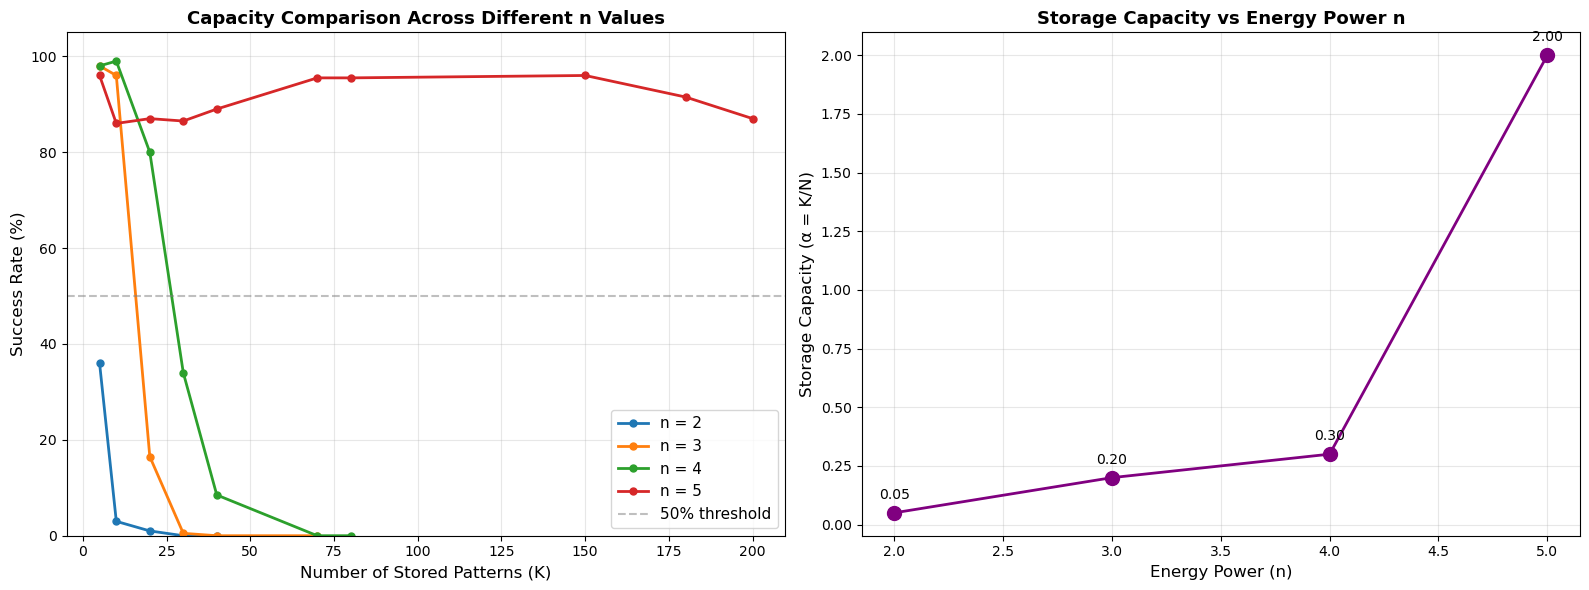

In [18]:
# Compare capacities across different n values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Success rates for all n values on same plot
for n in n_values_capacity:
    data = capacity_results[n]
    ax1.plot(data['K'], data['success_rates'], 'o-', linewidth=2, markersize=5,
            label=f'n = {n}')

ax1.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='50% threshold')
ax1.set_xlabel('Number of Stored Patterns (K)', fontsize=12)
ax1.set_ylabel('Success Rate (%)', fontsize=12)
ax1.set_title('Capacity Comparison Across Different n Values', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)
ax1.set_ylim([0, 105])

# Plot 2: Storage capacity (α = K/N) vs n
n_array = []
alpha_array = []
for n in n_values_capacity:
    n_array.append(n)
    alpha_array.append(capacity_estimates[n]['alpha'])

ax2.plot(n_array, alpha_array, 'o-', linewidth=2, markersize=10, color='purple')
ax2.set_xlabel('Energy Power (n)', fontsize=12)
ax2.set_ylabel('Storage Capacity (α = K/N)', fontsize=12)
ax2.set_title('Storage Capacity vs Energy Power n', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add value labels
for n, alpha in zip(n_array, alpha_array):
    ax2.annotate(f'{alpha:.2f}', (n, alpha), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

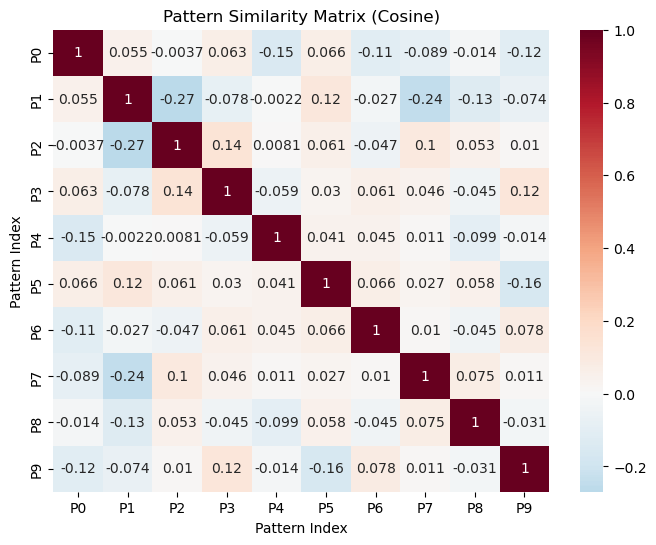

mem_term:  -269086.50061443925
reg_term:  164217.57109806768
mem_term:  -287642.49537021626
reg_term:  161538.97203435734
mem_term:  -359042.4027585499
reg_term:  170452.29096348328
mem_term:  -449441.8275319404
reg_term:  181237.77402709264
mem_term:  -509418.3167984677
reg_term:  186844.6004237411
mem_term:  -589689.3769644811
reg_term:  195071.62030152342
mem_term:  -699180.9802308067
reg_term:  204364.32618618006
mem_term:  -803038.1605701717
reg_term:  215868.47777976602
mem_term:  -833964.5165335112
reg_term:  220597.44451826904
mem_term:  -898964.0525263472
reg_term:  227971.59877565718
mem_term:  -958032.4088314142
reg_term:  234440.17122748157
mem_term:  -1050769.2637638573
reg_term:  242623.6346494947
mem_term:  -1221131.1984518126
reg_term:  250294.58017670567
mem_term:  -1359532.5262532716
reg_term:  257133.99718811762
mem_term:  -1519053.7520597996
reg_term:  262243.1888109522
mem_term:  -1606192.0969032715
reg_term:  268342.437590704
mem_term:  -1701714.7806848872
reg_ter

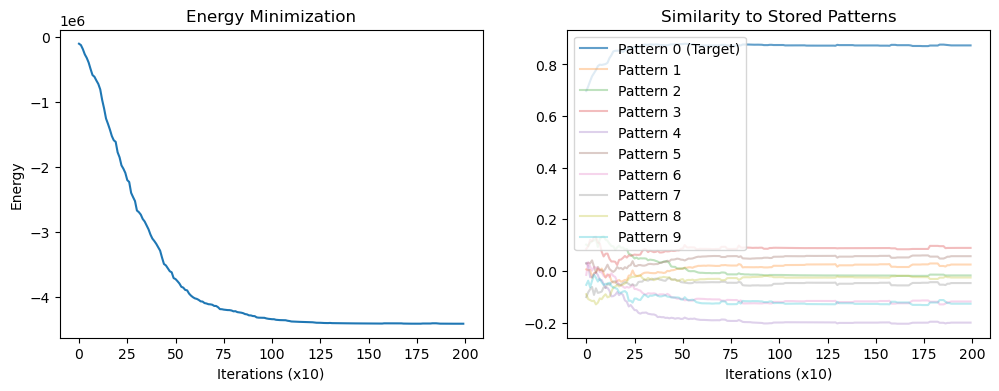

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from DAM import DenseAssociativeMemory
import seaborn as sns

def plot_pattern_correlations(patterns):
    """
    Computes and plots the cosine similarity between all pairs of stored patterns.
    """
    K = patterns.shape[0]
    similarity_matrix = np.zeros((K, K))
    
    for i in range(K):
        for j in range(K):
            similarity_matrix[i, j] = cosine(patterns[i], patterns[j])
            
    plt.figure(figsize=(8, 6))
    sns.heatmap(similarity_matrix, annot=True, cmap='RdBu_r', center=0,
                xticklabels=[f"P{i}" for i in range(K)],
                yticklabels=[f"P{i}" for i in range(K)])
    plt.title("Pattern Similarity Matrix (Cosine)")
    plt.xlabel("Pattern Index")
    plt.ylabel("Pattern Index")
    plt.show()


def test_dam_retrieval():
    N = 100   
    K = 10    
    n = 4     
    beta = 0.01    
    alpha = 0.5  
    noise_lvl = 0.5
    
    # Generate Random Patterns in (-1, 1)
    # We use sign then scale slightly to keep them near the boundaries but continuous
    patterns = np.random.uniform(-1, 1, (K, N))
    # plot the correlations between the patterns
    plot_pattern_correlations(patterns)
    # initialize Model
    dam = DenseAssociativeMemory(patterns, n=n, beta=beta, alpha=alpha, lmbda=9000)
    
    # create a noisy query
    target_idx = 0
    target_pattern = patterns[target_idx]
    noisy_query = target_pattern + np.random.normal(0, noise_lvl, N)
    noisy_query = np.clip(noisy_query, -1, 1) # keep within bounds
    
    # we run N * 20 steps to ensure every neuron is updated many times
    retrieved_state, best_match, energy_trace, sim_trace = dam.retrieve_differential(
        noisy_query, steps=N * 20
    )
    
    # evaluation
    initial_sim = cosine(target_pattern, noisy_query)
    final_sim = cosine(target_pattern, retrieved_state)
    
    print(f"--- Retrieval Test (Pattern {target_idx}) ---")
    print(f"Initial Cosine Similarity: {initial_sim:.4f}")
    print(f"Final Cosine Similarity:   {final_sim:.4f}")

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    
    ax[0].plot(energy_trace)
    ax[0].set_title("Energy Minimization")
    ax[0].set_xlabel("Iterations (x10)")
    ax[0].set_ylabel("Energy")
    
    # Plot similarity to all patterns over time
    sim_trace_array = np.array(sim_trace)
    for k in range(K):
        label = f"Pattern {k}" + (" (Target)" if k == target_idx else "")
        ax[1].plot(sim_trace_array[:, k], label=label, alpha=0.7 if k == target_idx else 0.3)
    
    ax[1].set_title("Similarity to Stored Patterns")
    ax[1].set_xlabel("Iterations (x10)")
    ax[1].legend()
    plt.show()

test_dam_retrieval()

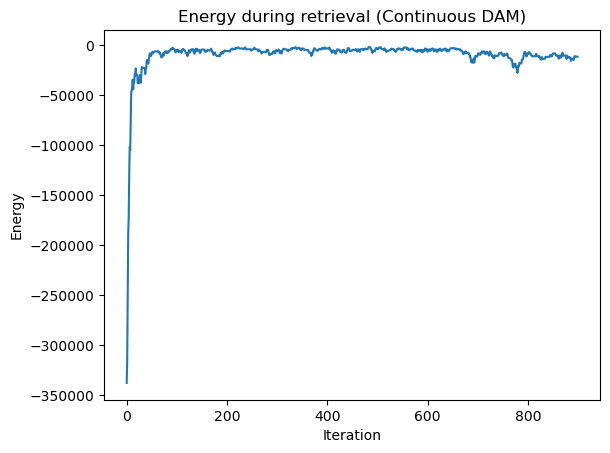

Cosine with true pattern: 0.24398380897466207
Cosine with all patterns:  [0.24398380897466207, 0.5918422068745726, -0.18988351616618385, -0.027014937719656813, 0.06901578711038658, 0.5881628841372891, 0.14675879071444048, 0.048795851617151303, -0.01771689324209665, 0.27219678230078387, -0.2994882687438729, -0.03348544358048781, 0.18332431271192887, -0.45085438486056006, -0.021651656736320413]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from DAM import DenseAssociativeMemory

# simple random patterns for testing
K = 15
N = 20
"""
Track changes for different values for the relaxation paramaters

"""
patterns = np.random.choice([-1,1], size=(K,N))

dam = DenseAssociativeMemory(patterns, n=4, beta=2.0, alpha=0.5)

# pick one pattern and add gaussian noise
target = patterns[0].copy()
noisy = target + 0.5*np.random.randn(N)

retrieved, best, energy_trace, simi_trace = dam.retrieve(noisy, steps=900)

plt.plot(energy_trace)
plt.title("Energy during retrieval (Continuous DAM)")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.show()

print("Cosine with true pattern:", cosine(retrieved, target))
cosine_with_all = [cosine(retrieved, pattern) for pattern in patterns]
print("Cosine with all patterns: ", cosine_with_all)


In [111]:
import numpy as np
import matplotlib.pyplot as plt
from DAM import DenseAssociativeMemory
N = 5         
ks = [1, 5, 10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 300, 400, 500, 600, 700, 800, 900]        
steps = 500       
noise_std = 0.8   
tolerance = 0.1   

K_values = []
recall_counts = []

for K in ks:
    patterns = np.random.choice([-1,1], size=(K,N))
    
    dam = DenseAssociativeMemory(patterns, n=2, beta=2, alpha=0.1)
    
    average_recall_simi = 0
    correct_recalls = 0
    for i in range(K):
        target = patterns[i].copy()
        noisy = target + noise_std*np.random.randn(N)
        retrieved, best, energy_trace, simi_trace = dam.retrieve_differential(noisy, steps=steps)

        if (1 - cosine(retrieved, target)) <= tolerance:
            correct_recalls += 1
        average_recall_simi += cosine(retrieved, target)

    average_recall_simi /= K
    K_values.append(K)
    recall_counts.append(correct_recalls / K)
    print(f"K={K}, correctly recalled: {correct_recalls/K * 100}% with average recall accuracy of {average_recall_simi}")

plt.figure(figsize=(8,5))
plt.plot(K_values, recall_counts, marker='o')
plt.xlabel("Number of stored patterns K")
plt.ylabel("Number of correctly recalled patterns")
plt.title("DAM Recall Performance vs Number of Patterns")
plt.grid(True)
plt.show()


K=2, Success Rate: 100.0%
K=10, Success Rate: 70.0%
K=50, Success Rate: 56.0%
K=100, Success Rate: 56.0%
K=200, Success Rate: 54.0%
K=400, Success Rate: 60.0%


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Fix: Use Binary Patterns for Clear Retrieval ---
N = 100         
ks = [2, 10, 50, 100, 200, 400, 600] 
steps = 1000       # N=100 needs time to settle
noise_std = 0.2    # Standard noise
tolerance = 0.9    # We'll check for similarity >= 0.9

def cosine(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-12)

results = []

for K in ks:
    # Use Binary Patterns (-1, 1)
    patterns = np.random.choice([-1.0, 1.0], size=(K, N))
    
    # beta=1.0 is usually enough when patterns are not normalized to 1.0
    dam = DenseAssociativeMemory(patterns, n=4, beta=1.0, alpha=0.3)
    
    correct_recalls = 0
    # We only test a subset of K for speed if K is huge
    test_limit = min(K, 50) 
    
    for i in range(test_limit):
        target = patterns[i].copy()
        noisy = target + noise_std * np.random.randn(N)
        
        retrieved, _, _, _ = dam.retrieve_differential(noisy, steps=steps)

        # Check success
        if cosine(retrieved, target) >= tolerance:
            correct_recalls += 1

    success_rate = correct_recalls / test_limit
    results.append(success_rate)
    print(f"K={K}, Success Rate: {success_rate*100:.1f}%")

plt.figure(figsize=(8, 5))
plt.plot(ks, results, 'o-', color='blue', linewidth=2)
plt.axhline(y=0.9, color='r', linestyle='--', label="High Reliability Zone")
plt.xlabel("Number of Patterns (K)")
plt.ylabel("Success Rate")
plt.title(f"DAM Capacity: The 'Cliff' (N={N}, n=4)")
plt.grid(True)
plt.legend()
plt.show()

In [5]:
N = 100         
max_K = 50        
steps = 500       
noise_std = 0.5   
tolerance = 0.1   

K_values = []
recall_counts = []

for K in range(1, max_K + 1):
    patterns = np.random.choice([-1,1], size=(K,N))
    dam = DenseAssociativeMemory(patterns, n=4, beta=2, alpha=1)
    
    average_recall_simi = 0
    correct_recalls = 0
    for i in range(K):
        target = patterns[i].copy()
        noisy = target + noise_std*np.random.randn(N)
        retrieved, best, trace = dam.retrieve(noisy, steps=steps)

        if (1 - cosine(best, target)) <= tolerance:
            correct_recalls += 1
        average_recall_simi += cosine(retrieved, target)

    average_recall_simi /= K
    K_values.append(K)
    recall_counts.append(correct_recalls)
    print(f"K={K}, correctly recalled: {correct_recalls}/{K} with average recall accuracy of {average_recall_simi}")

plt.figure(figsize=(8,5))
plt.plot(K_values, recall_counts, marker='o')
plt.xlabel("Number of stored patterns K")
plt.ylabel("Number of correctly recalled patterns")
plt.title("DAM Recall Performance vs Number of Patterns")
plt.grid(True)
plt.show()


ValueError: too many values to unpack (expected 3)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from DAM import DenseAssociativeMemory
N = 20        
max_K = 50        
steps = 500       
noise_std = 0.5   
tolerance = 0.1   

K_values = []
recall_counts = []

for K in range(1, max_K + 1):
    patterns = np.random.choice([-1,1], size=(K,N))
    dam = DenseAssociativeMemory(patterns, n=4, beta=2, alpha=0.2)
    
    average_recall_simi = 0
    correct_recalls = 0
    for i in range(K):
        target = patterns[i].copy()
        noisy = target + noise_std*np.random.randn(N)
        retrieved, best, trace = dam.retrieve(noisy, steps=steps)

        if (1 - cosine(best, target)) <= tolerance:
            correct_recalls += 1
        average_recall_simi += cosine(retrieved, target)

    average_recall_simi /= K
    K_values.append(K)
    recall_counts.append(correct_recalls)
    print(f"K={K}, correctly recalled: {correct_recalls}/{K} with average recall accuracy of {average_recall_simi}")

plt.figure(figsize=(8,5))
plt.plot(K_values, recall_counts, marker='o')
plt.xlabel("Number of stored patterns K")
plt.ylabel("Number of correctly recalled patterns")
plt.title("DAM Recall Performance vs Number of Patterns")
plt.grid(True)
plt.show()


ValueError: too many values to unpack (expected 3)

### How similarity with stored patterns evolves with iterations for $\alpha = 0.1$ (i.e. slowly updating the neuron's value)
Observation: The state first starts off with a simiarity of value $x$ with the target. It then starts decreasing with no limit apparently. The reason that the model was able to retrieve every single state for a small alpha value was that, even with noise, the initial noisy state was closest to the target pattern out of all the other patterns. And with small $\alpha$, we didn't deviate much from that state and we recover the pattern correctly. But if you use a higher value of alpha, the way that the vector is degrading is going to be apparent.

0.7516729120725171


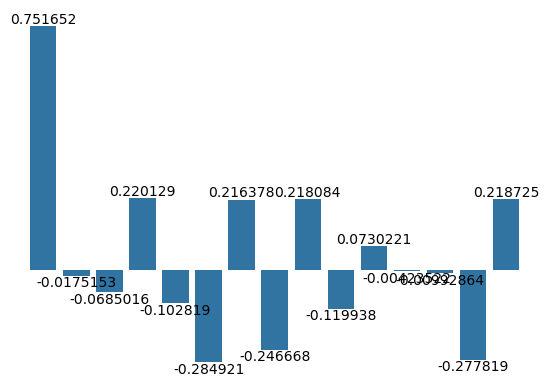

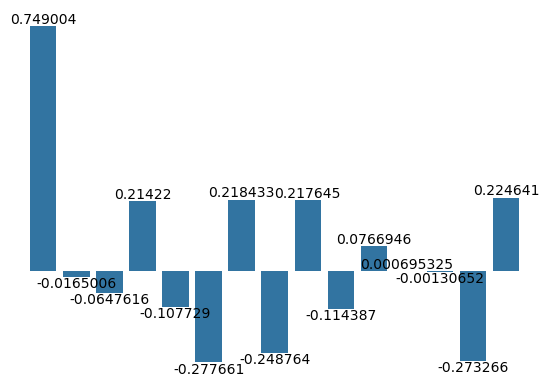

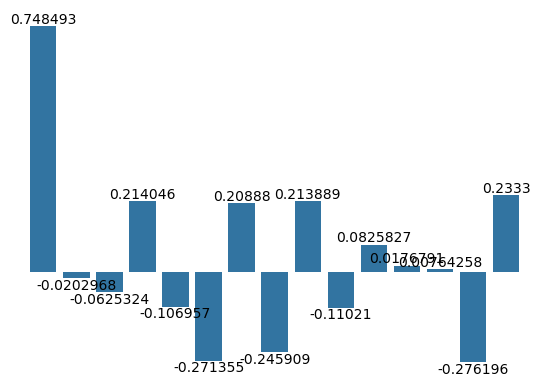

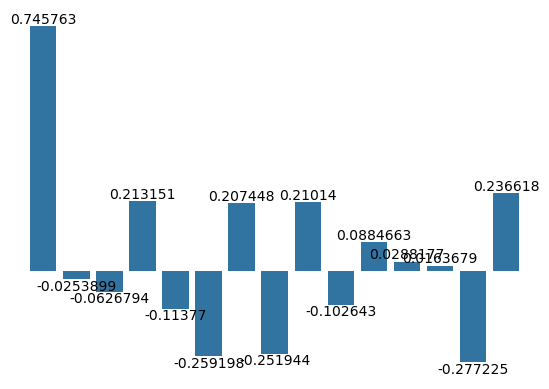

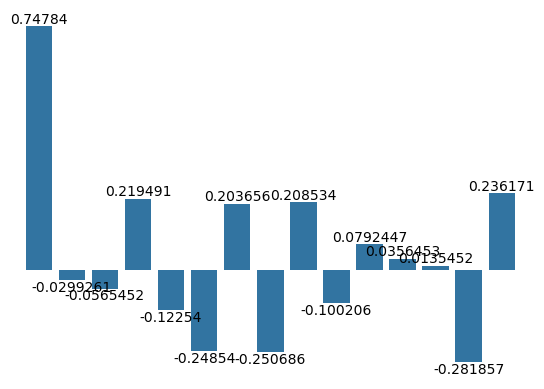

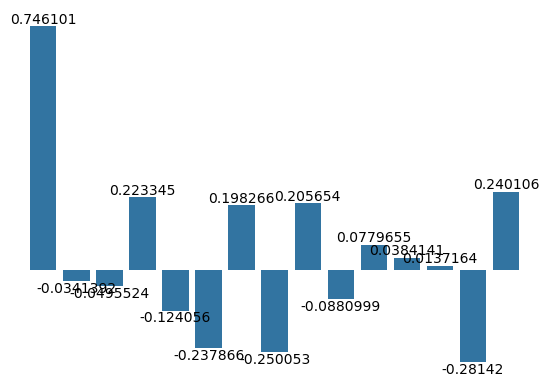

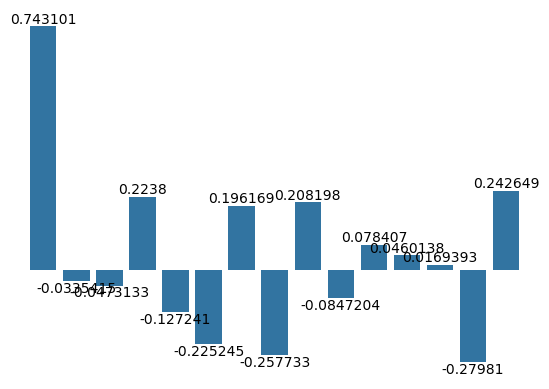

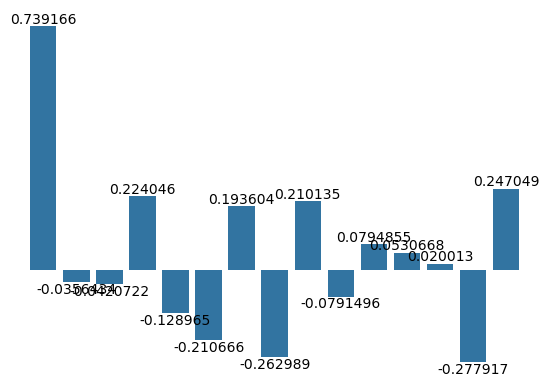

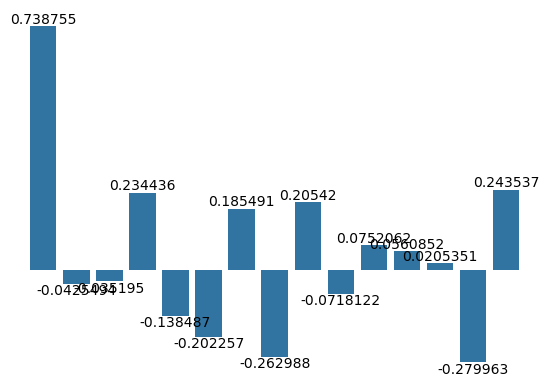

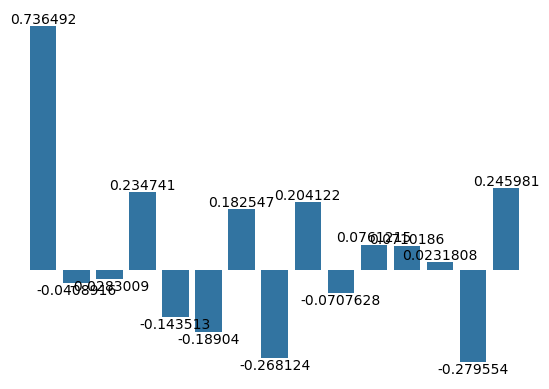

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from DAM import DenseAssociativeMemory

K = 15
N = 30

patterns = np.random.choice([-1,1], size=(K,N))

dam = DenseAssociativeMemory(patterns, n=4, beta=2.0, alpha=0.01)

# pick one pattern and add gaussian noise
target = patterns[0].copy()
noisy = target + 1*np.random.randn(N)
simi_noisy_target = np.dot(noisy, target) / (np.linalg.norm(noisy) * np.linalg.norm(target) + 1e-12)
print(simi_noisy_target)

retrieved, best, energy_trace, similarity_trace = dam.retrieve(noisy, steps=1000)

for i in range(0, 1000, 100):
    ax = sns.barplot(x=np.arange(len(similarity_trace[i])), y=similarity_trace[i])
    ax.bar_label(ax.containers[0])
    plt.axis('off')
    plt.show()

### How similarity with stored patterns evolves with iterations for $\alpha = 0.5$

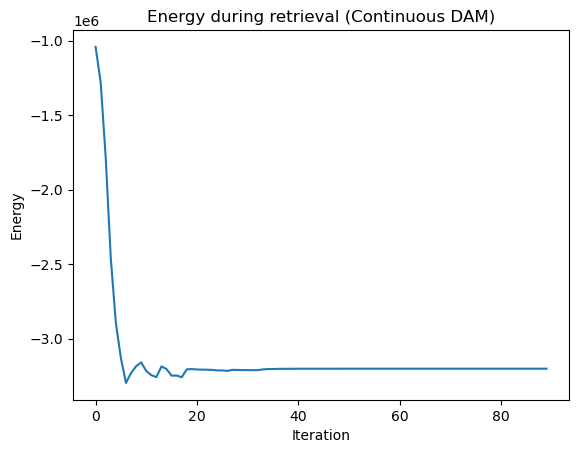

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from DAM import DenseAssociativeMemory

# simple random patterns for testing
K = 15
N = 20
"""
Track changes for different values for the relaxation paramaters

"""
patterns = np.random.choice([-1,1], size=(K,N))

dam = DenseAssociativeMemory(patterns, n=5, beta=2.0, alpha=0.5)

# pick one pattern and add gaussian noise
target = patterns[0].copy()
noisy = target + 0.5*np.random.randn(N)

retrieved, best, energy_trace, similarity_trace = dam.retrieve_differential(noisy, steps=900)

plt.plot(energy_trace)
plt.title("Energy during retrieval (Continuous DAM)")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.show()



0.6051457908653775
1000


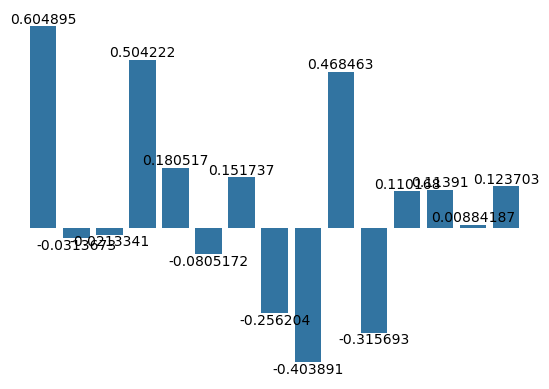

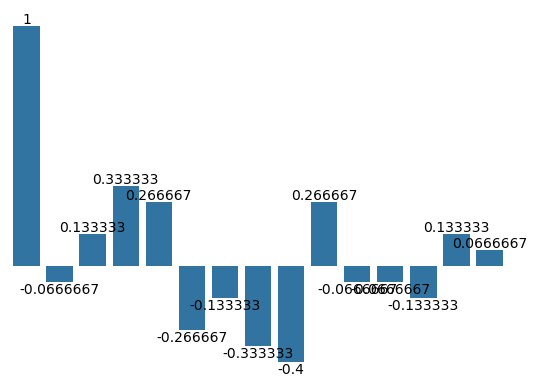

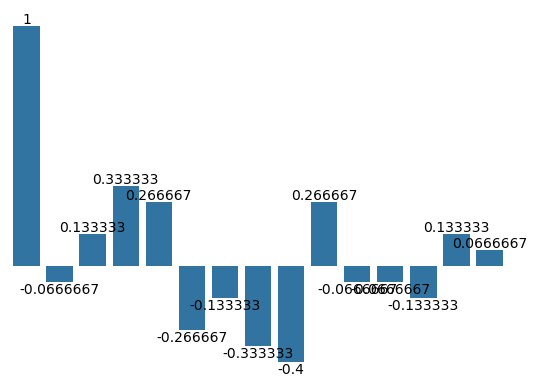

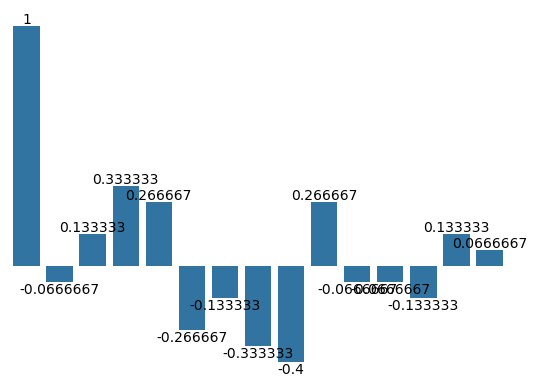

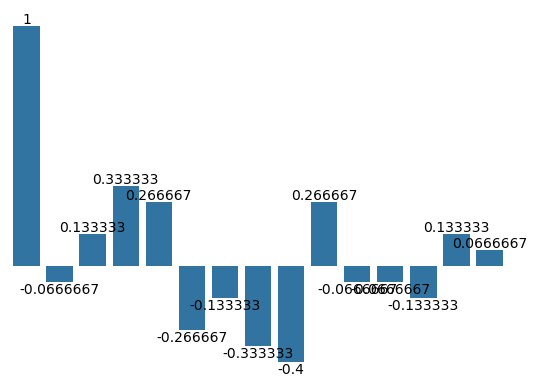

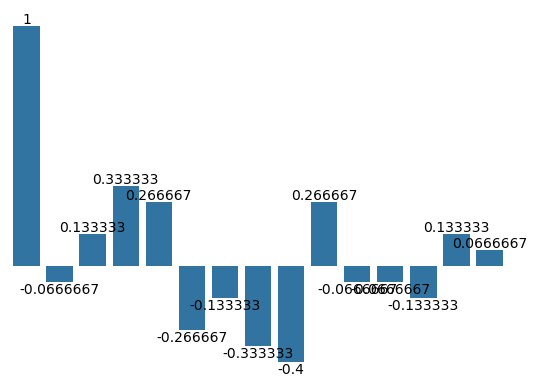

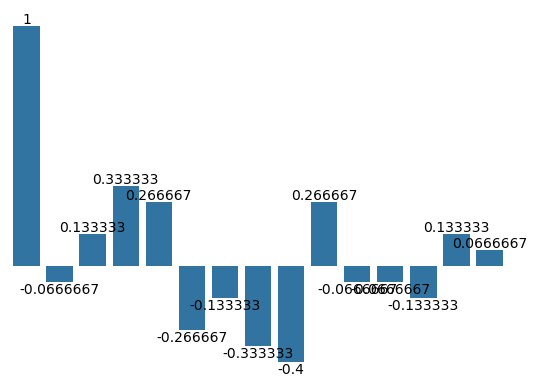

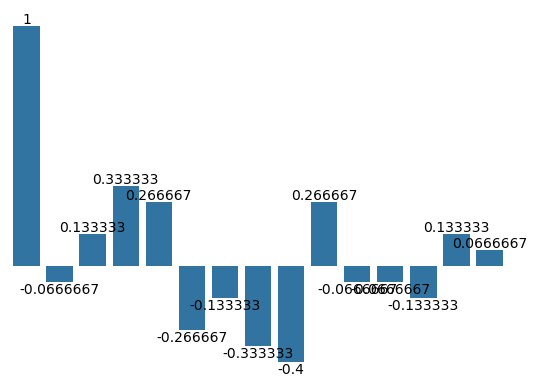

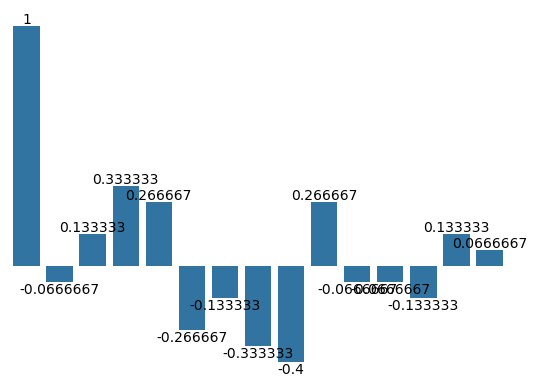

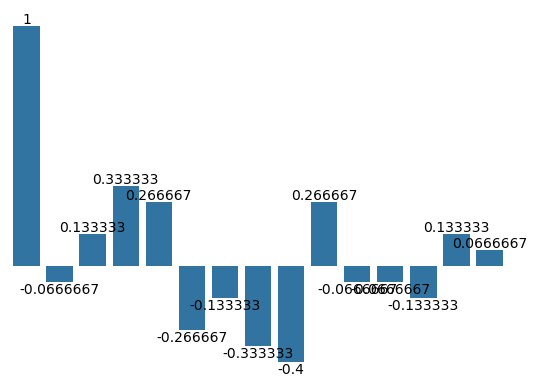

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from DAM import DenseAssociativeMemory

K = 15
N = 30

patterns = np.random.choice([-1,1], size=(K,N))

dam = DenseAssociativeMemory(patterns, n=5, beta=2.0, alpha=0.6)

# pick one pattern and add gaussian noise
target = patterns[0].copy()
noisy = target + 1*np.random.randn(N)
simi_noisy_target = np.dot(noisy, target) / (np.linalg.norm(noisy) * np.linalg.norm(target) + 1e-12)
print(simi_noisy_target)

retrieved, best, energy_trace, similarity_trace = dam.retrieve_differential(noisy, steps=10000)
print(len(similarity_trace))

for i in range(0, len(similarity_trace), 100):
    ax = sns.barplot(x=np.arange(len(similarity_trace[i])), y=similarity_trace[i])
    ax.bar_label(ax.containers[0])
    plt.axis('off')
    plt.show()

## Experiemnts

### The $\beta$ sweep

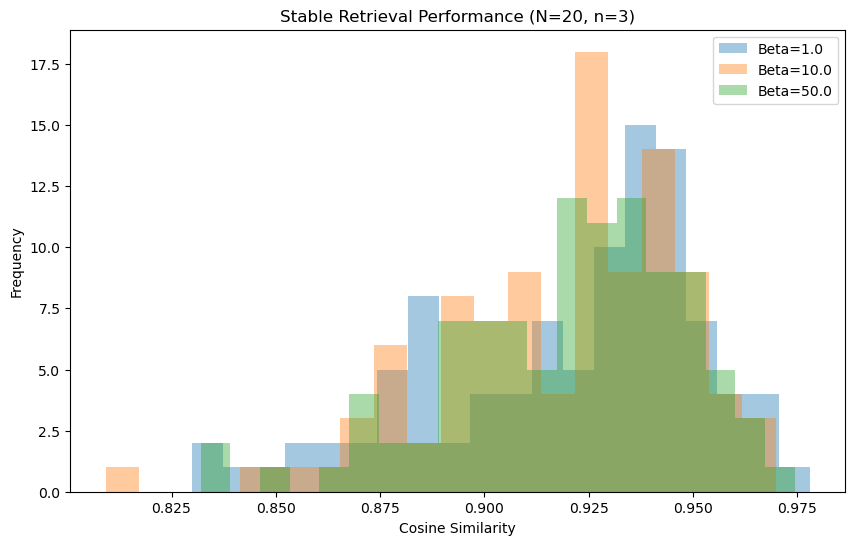

In [62]:
N = 20       # Increased for stability
K = 600        # Higher K, but manageable for n=3
n_power = 3   # Using the Dense property
num_worlds = 5 # Test across 5 different random pattern sets
trials_per_world = 20 

betas = [1.0, 10.0, 50.0]
plt.figure(figsize=(10, 6))

for b in betas:
    all_similarities = []
    for w in range(num_worlds):
        # Fresh patterns for every 'world'
        patterns = np.random.choice([-1.0, 1.0], size=(K, N))
        dam = DenseAssociativeMemory(patterns, n=n_power, beta=b, alpha=0.1)
        
        for _ in range(trials_per_world):
            target = patterns[0]
            noisy = target + 0.5 * np.random.randn(N)
            # Shortened steps since N is larger
            retrieved, _, _, _ = dam.retrieve_differential(noisy, steps=N*2)
            all_similarities.append(cosine(retrieved, target))
    
    plt.hist(all_similarities, bins=20, alpha=0.4, label=f'Beta={b}')

plt.title(f"Stable Retrieval Performance (N={N}, n={n_power})")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

[2, 7, 5, 8, 5, 8, 7, 5, 7, 5, 7, 7, 7, 2, 7, 8, 9, 7, 5, 2, 4, 5, 8, 8, 6, 7, 7, 8, 3, 6, 5, 12, 7, 6, 4, 6, 7, 5, 5, 5, 8, 5, 3, 5, 8, 3, 9, 6, 5, 8]
[10, 9, 9, 9, 5, 6, 9, 5, 10, 7, 12, 11, 8, 13, 9, 9, 9, 3, 6, 6, 5, 10, 8, 11, 10, 12, 8, 10, 8, 4, 11, 11, 12, 10, 9, 7, 9, 8, 10, 11, 10, 9, 13, 10, 8, 7, 9, 7, 5, 9]
[14, 10, 12, 9, 10, 9, 4, 13, 9, 7, 12, 9, 8, 16, 10, 9, 7, 9, 11, 12, 5, 7, 9, 11, 10, 12, 7, 11, 11, 9, 10, 9, 9, 7, 9, 10, 9, 6, 6, 6, 7, 6, 9, 10, 11, 8, 9, 9, 8, 9]
[12, 11, 10, 8, 8, 9, 12, 9, 11, 10, 8, 8, 8, 7, 9, 5, 11, 11, 10, 9, 8, 8, 6, 8, 11, 7, 4, 8, 7, 6, 11, 9, 9, 8, 10, 8, 9, 8, 9, 3, 7, 13, 7, 10, 10, 9, 6, 8, 6, 10]
[8, 9, 12, 8, 7, 5, 10, 10, 11, 14, 7, 8, 8, 13, 12, 6, 10, 11, 10, 10, 12, 8, 10, 8, 5, 5, 8, 11, 7, 11, 9, 8, 7, 8, 7, 8, 4, 13, 10, 15, 11, 8, 8, 12, 11, 10, 7, 6, 5, 5]
[8, 10, 8, 8, 8, 7, 15, 8, 10, 9, 6, 12, 8, 7, 9, 14, 11, 6, 9, 10, 12, 9, 8, 6, 9, 8, 7, 13, 10, 7, 8, 12, 4, 12, 4, 7, 12, 7, 5, 6, 7, 5, 9, 7, 8, 8, 8, 9, 8, 10]
[9,

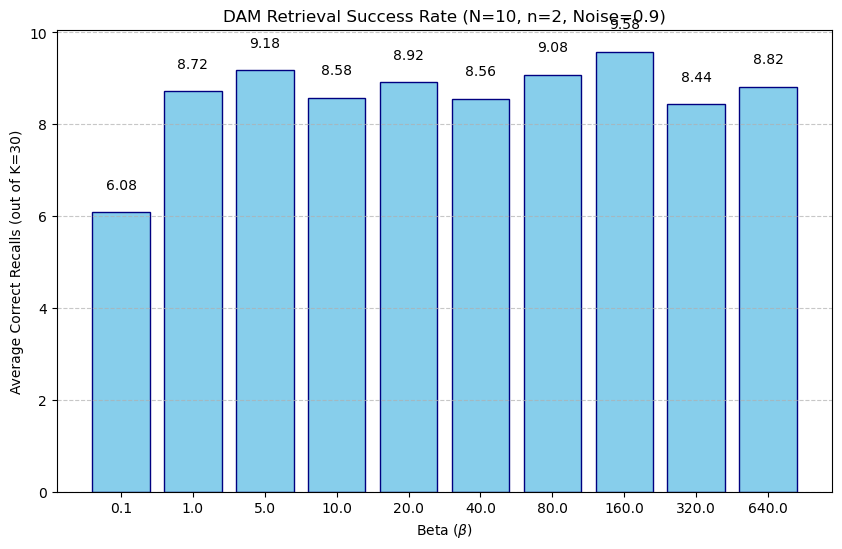

In [85]:
import numpy as np
import matplotlib.pyplot as plt

N = 10
K = 30
n_power = 2        
betas = [0.1, 1.0, 5.0, 10.0, 20.0, 40.0, 80.0, 160.0, 320.0, 640.0]
noise_level = 0.8  
tolerance = 0.90    
num_trials = 50

avg_recalls_per_beta = []

for b in betas:
    trial_counts = []
    for t in range(num_trials):
        patterns = np.random.choice([-1.0, 1.0], size=(K, N))
        
        dam = DenseAssociativeMemory(patterns, n=n_power, beta=b, alpha=0.1)
        
        correct_recalls = 0
        for i in range(K):
            target = patterns[i]
            noisy = target + noise_level * np.random.randn(N)
            
            retrieved, _, _, _ = dam.retrieve_differential(noisy, steps=100)
            
            if cosine(retrieved, target) >= tolerance:
                correct_recalls += 1
        
        trial_counts.append(correct_recalls)
    avg_recalls_per_beta.append(np.mean(trial_counts))

plt.figure(figsize=(10, 6))
bars = plt.bar([str(b) for b in betas], avg_recalls_per_beta, color='skyblue', edgecolor='navy')
plt.xlabel("Beta ($\\beta$)")
plt.ylabel(f"Average Correct Recalls (out of K={K})")
plt.title(f"DAM Retrieval Success Rate (N={N}, n={n_power}, Noise={noise_level})")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()